In [1]:
# import all the necessary libraries for time-seires analysis and network analysis
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import os
import sys
import math
import random
import itertools
import operator
import collections
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
import osmnx as ox
import contextily as ctx
import geopandas as gpd
import numpy as np
import pandas as pd
import networkx as nx
import pygenstability as pgs
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.sparse import csr_array, csr_matrix
from scipy.sparse.csgraph import shortest_path
from pygenstability import plotting
from networkx.algorithms.community import modularity

c:\Users\SBH\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from scipy.linalg import inv

def compute_affinity_matrix(G, epsilon=0.01, sorted_nodes=None):
    # 获取邻接矩阵
    A = nx.to_numpy_array(G, nodelist=sorted_nodes, weight='weight')
    # 节点数量
    n = A.shape[0]
    # 度矩阵
    D = np.diag([G.degree(i) for i in G.nodes()])
    # 传播矩阵计算
    S = inv(np.eye(n) + epsilon**2 * D - epsilon * A)
    return S

def delta_con(G1, G2, epsilon=0.01, sorted_nodes=None):
    S_G1 = compute_affinity_matrix(G1, epsilon, sorted_nodes=sorted_nodes)
    S_G2 = compute_affinity_matrix(G2, epsilon, sorted_nodes=sorted_nodes)
    
    # 计算传播距离差异矩阵
    delta = np.sqrt(np.abs(S_G1 - S_G2))
    
    # 计算DeltaCon全局相似度
    delta_con_score = 1 / (1 + np.sum(delta))
    
    return delta_con_score

In [3]:
sorted_nodelist = ['Anqing, Anhui, China',
 'Changzhou, Jiangsu, China',
 'Chizhou, Anhui, China',
 'Chuzhou, Anhui, China',
 'Hangzhou City, Zhejiang, China',
 'Hefei, Anhui, China',
 'Huzhou, Zhejiang, China',
 'Jiaxing, Zhejiang, China',
 'Jinhua, Zhejiang, China',
 "Ma'anshan, Anhui, China",
 'Nanjing, Jiangsu, China',
 'Nantong, Jiangsu, China',
 'Ningbo, Zhejiang, China',
 'Shanghai, China',
 'Shaoxing, Zhejiang, China',
 'Suzhou City, Jiangsu, China',
 'Taizhou, Jiangsu, China',
 'Taizhou, Zhejiang, China',
 'Tongling, Anhui, China',
 'Wuhu, Anhui, China',
 'Wuxi City, Jiangsu, China',
 'Xuancheng, Anhui, China',
 'Yancheng City, Jiangsu, China',
 'Yangzhou City, Jiangsu, China',
 'Zhenjiang, Jiangsu, China',
 'Zhoushan, Zhejiang, China']

In [4]:
# create a dataframe to store the results
results = pd.DataFrame(columns=["year", "measure", "d_road_eco", "d_eco_road", "F_road_road", "F_road_eco", "F_eco_road", "F_eco_eco","d_road_eco_control", "d_eco_road_control", "F_road_road_control", "F_road_eco_control", "F_eco_road_control", "F_eco_eco_control", "DeltaCon", "DeltaCon_control"])
# fill the "year" column from 2013 to 2023
results["year"] = range(2013, 2024)
# fill the "measure" column with "Modularity"
results["measure"] = "Modularity"
results

year     measure d_road_eco d_eco_road F_road_road F_road_eco F_eco_road  \
0   2013  Modularity        NaN        NaN         NaN        NaN        NaN   
1   2014  Modularity        NaN        NaN         NaN        NaN        NaN   
2   2015  Modularity        NaN        NaN         NaN        NaN        NaN   
3   2016  Modularity        NaN        NaN         NaN        NaN        NaN   
4   2017  Modularity        NaN        NaN         NaN        NaN        NaN   
5   2018  Modularity        NaN        NaN         NaN        NaN        NaN   
6   2019  Modularity        NaN        NaN         NaN        NaN        NaN   
7   2020  Modularity        NaN        NaN         NaN        NaN        NaN   
8   2021  Modularity        NaN        NaN         NaN        NaN        NaN   
9   2022  Modularity        NaN        NaN         NaN        NaN        NaN   
10  2023  Modularity        NaN        NaN         NaN        NaN        NaN   

   F_eco_eco d_road_eco_control d_eco_road_control F_road_road_control  \
0        NaN                NaN                NaN                 NaN   
1        NaN                NaN                NaN                 NaN   
2        NaN                NaN                NaN                 NaN   
3        NaN                NaN                NaN                 NaN   
4        NaN                NaN                NaN                 NaN   
5        NaN                NaN                NaN                 NaN   
6        NaN                NaN                NaN                 NaN   
7        NaN                NaN                NaN                 NaN   
8        NaN                NaN                NaN                 NaN   
9        NaN                NaN                NaN                 NaN   
10       NaN                NaN                NaN                 NaN   

   F_road_eco_control F_eco_road_control F_eco_eco_control DeltaCon  \
0                 NaN                NaN               NaN      NaN   
1                 NaN                NaN               NaN      NaN   
2                 NaN                NaN               NaN      NaN   
3                 NaN                NaN               NaN      NaN   
4                 NaN                NaN               NaN      NaN   
5                 NaN                NaN               NaN      NaN   
6                 NaN                NaN               NaN      NaN   
7                 NaN                NaN               NaN      NaN   
8                 NaN                NaN               NaN      NaN   
9                 NaN                NaN               NaN      NaN   
10                NaN                NaN               NaN      NaN   

   DeltaCon_control  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
5               NaN  
6               NaN  
7               NaN  
8               NaN  
9               NaN  
10              NaN

In [5]:
for year in range(2013, 2024):

    # import the BEA code dataset
    BEA = pd.read_csv('Data/python/BEAcode.csv')
    # remove all the NA columns in the dataset
    BEA = BEA.dropna(axis=1, how='all')

    # import the CN code dataset
    CN = pd.read_csv('Data/python/CNcode.csv')
    # remove all the NA columns in the dataset
    CN = CN.dropna(axis=1, how='all')
    # remove all the NA rows in the dataset
    CN = CN.dropna(axis=0, how='all')
    # change the CN_code column to integer
    CN['CN_code'] = CN['CN_code'].astype(int)

    # import the concordance dataset
    concordance = pd.read_csv('Data/python/Concordance.csv')
    # remove all the NA columns in the dataset
    concordance = concordance.dropna(axis=1, how='all')
    # remove all the NA rows in the dataset
    concordance = concordance.dropna(axis=0, how='all')

    # import the matrix dataset, and set the first column as the index
    matrix = pd.read_csv('Data/python/IOMatrix.csv', index_col=0)
    # fill all the NA values with 0
    matrix = matrix.fillna(0)
    # convert all the values in the matrix to float
    matrix = matrix.astype(float)
    # for each value in the matrix, divide it by the last column's value of this row , last column is 'total'
    matrix = matrix.div(matrix['total'], axis=0)
    # drop the last column of the matrix
    matrix = matrix.drop('total', axis=1)

    # c reate a 23*23 matrix to store the summary results
    CN_codelist = concordance['concordance_CN_code'].unique()
    result_matrix = pd.DataFrame(np.zeros((len(CN_codelist), len(CN_codelist))), 
                                index=CN_codelist, columns=CN_codelist)


    # delete all the commas in the matrix so as to convert all values to float
    matrix = matrix.replace(',', '', regex=True)
    # convert all the values in the matrix to float
    matrix = matrix.astype(float)

    for CN_code_i in CN_codelist:
        for CN_code_j in CN_codelist:
            BEA_code_i = concordance[concordance['concordance_CN_code'] == CN_code_i]['IO_code_BEA'].values[0]
            BEA_code_j = concordance[concordance['concordance_CN_code'] == CN_code_j]['IO_code_BEA'].values[0]
            result_matrix.loc[CN_code_i, CN_code_j] = matrix.loc[BEA_code_i, BEA_code_j].sum().sum()

    path = f'Data/python/CityIndustry/CityIndustry{year}.csv'
    city_GDP = pd.read_csv(path, index_col=0,header=0)
    # convert all the values in the city_GDP to float
    city_GDP = city_GDP.astype(float)
    # and fill all the NA values with 0
    city_GDP = city_GDP.fillna(0)
    # reindex  result_matrix 's index based on city's index
    result_matrix_reindex = result_matrix.reindex(city_GDP.index)
    #  reorder  result_matrix 's columns based on city's index
    result_matrix_reindex = result_matrix_reindex.reindex(columns=city_GDP.index)
    # normalize the result matrix by each column?
    result_matrix_reindex_norm = result_matrix_reindex.reindex(columns=city_GDP.index)


    # normalize the city_GDP by each row
    city_GDP_norm_row = city_GDP.div(city_GDP.sum(axis=1), axis=0)
    city_GDP_norm_column = city_GDP.div(city_GDP.sum(axis=0), axis=1)
    # take the log of the city GDP matrix
    city_GDP_all_log = np.log(city_GDP + 1)

    # left multiply the result matrix with the city matrix to get the demand matrix from each city's GDP to each industry
    # this step, we could get how much demand each city have towards each industry in order to get their production
    Demand_city_matrix_all = result_matrix_reindex_norm.dot(city_GDP)

    # normalize the demand matrix by each row and column
    Demand_norm_row = Demand_city_matrix_all.div(Demand_city_matrix_all.sum(axis=1), axis=0)
    Demand_norm_column = Demand_city_matrix_all.div(Demand_city_matrix_all.sum(axis=0), axis=1)
    # take the log of the demand matrix
    Demand_city_matrix_all_log = np.log(Demand_city_matrix_all+1)

    # calculate the sum of each row in the city_GDP and save as an dictionary with index as the key
    Provide_city_matrix_dict = city_GDP.sum(axis=1).to_dict()
    Provide_city_matrix_sum = city_GDP.sum(axis=1)
    Demand_city_sum_dict = Demand_city_matrix_all.sum(axis=1).to_dict()
    Demand_city_sum = Demand_city_matrix_all.sum(axis=1)


    # create a 26*26 matrix to store the dependency relationship between cities
    city_list = city_GDP.columns

    # create an empty city_dependency_matrix and set the data type to object
    city_weighted_dependency_matrix = pd.DataFrame(index=city_list, columns=city_list, dtype=object)

    # initialize each cell in the DataFrame to an empty list
    for i in city_list:
        for j in city_list:
            city_weighted_dependency_matrix.loc[i, j] = []

    # calculate the proportion where city j's GDP contributes to city i's demand, means for each industry, how much will city i depend on city j
    # and for each city pair, sum the weighted dependency for each industry
    for i in city_list:
        for j in city_list:
            temp_dependency = city_GDP_norm_row.loc[:,j] * Demand_norm_row.loc[:, i] * Demand_city_matrix_all.loc[:, i] * city_GDP_norm_column.loc[:,i]
            temp_dependency = temp_dependency.fillna(0)
            # fill the infinities with the maximum value in the temp_dependency
            temp_dependency = temp_dependency.replace([np.inf, -np.inf], 0)
            #take the mean value of the temp_dependency as the dependency value
            depend_value = temp_dependency.sum()
            #depend_value = temp_dependency.sum()
            city_weighted_dependency_matrix.loc[i, j] = depend_value

    city_weighted_dependency_matrix = city_weighted_dependency_matrix.apply(pd.to_numeric, errors='coerce')
    city_weighted_dependency_matrix_norm = np.log(city_weighted_dependency_matrix + 1)
    
    # convert the city_weighted_dependency_matrix to a numpy array
    city_weighted_dependency_matrix_array = city_weighted_dependency_matrix_norm.to_numpy()
    # calculate the mean and standard deviation of the array
    mean_val = city_weighted_dependency_matrix_array.mean()
    std_val = city_weighted_dependency_matrix_array.std()
    # 进行 Z-score 归一化
    city_weighted_dependency_matrix_norm = (city_weighted_dependency_matrix_norm - mean_val) / std_val
    # take the exponential of the normalized matrix
    city_weighted_dependency_matrix_norm = np.exp(city_weighted_dependency_matrix_norm)
    

    #download the city's coordinates from the OpenStreetMap
    # construct the city'list for its specific name in OSM
    city_namelist_OSM = ['Suzhou City, Jiangsu, China','Yangzhou City, Jiangsu, China','Anqing, Anhui, China','Changzhou, Jiangsu, China', 'Chizhou, Anhui, China',
                    '滁州市','Hangzhou City, Zhejiang, China', 'Hefei, Anhui, China','Huzhou, Zhejiang, China','Jiaxing, Zhejiang, China',
                    'Jinhua, Zhejiang, China',"Ma'anshan, Anhui, China", 'Nanjing, Jiangsu, China','Nantong, Jiangsu, China','Ningbo, Zhejiang, China',
                    'Shaoxing, Zhejiang, China','Taizhou, Zhejiang, China','Taizhou, Jiangsu, China','Tongling, Anhui, China','Wuxi City, Jiangsu, China',
                    'Wuhu, Anhui, China','Xuancheng, Anhui, China','Yancheng City, Jiangsu, China','Zhenjiang, Jiangsu, China','Zhoushan, Zhejiang, China','Shanghai, China']
    city_namelist_OSM_en = ['Suzhou City, Jiangsu, China','Yangzhou City, Jiangsu, China','Anqing, Anhui, China','Changzhou, Jiangsu, China', 'Chizhou, Anhui, China',
                    'Chuzhou, Anhui, China','Hangzhou City, Zhejiang, China', 'Hefei, Anhui, China','Huzhou, Zhejiang, China','Jiaxing, Zhejiang, China',
                    'Jinhua, Zhejiang, China',"Ma'anshan, Anhui, China", 'Nanjing, Jiangsu, China','Nantong, Jiangsu, China','Ningbo, Zhejiang, China',
                    'Shaoxing, Zhejiang, China','Taizhou, Zhejiang, China','Taizhou, Jiangsu, China','Tongling, Anhui, China','Wuxi City, Jiangsu, China',
                    'Wuhu, Anhui, China','Xuancheng, Anhui, China','Yancheng City, Jiangsu, China','Zhenjiang, Jiangsu, China','Zhoushan, Zhejiang, China','Shanghai, China']

    # download each city's osmid and save it into a list
    city_osmid = []

    for city_name in city_namelist_OSM:
        try:
            # get the city's geographic data
            gdf = ox.geocode_to_gdf(city_name)
            city_osmid.append(gdf.osm_id.iloc[0])
        except Exception as e:
            print(f"Error retrieving data for {city_name}: {e}")


    # download each city's boundary data and center's coordinates data
    city_centers = {}

    # Iterate over the list of cities to get the boundary and center coordinates of each city
    for i in range(len(city_osmid)):
        try:
            # get the city's geographic data
            gdf = ox.geocode_to_gdf(f"R{city_osmid[i]}", by_osmid=True)
            
            # convert the geographic data to the Web Mercator projection
            gdf_projected = gdf.to_crs(epsg=4326)
            
            # get the center of the city coordinates
            center = gdf_projected.geometry.centroid.iloc[0]
            
            # save the city's center coordinates to a dict
            city_centers[city_namelist_OSM_en[i]] = (center.x, center.y)
            
    
        except Exception as e:
            print(f"Error retrieving data for {city_namelist_OSM_en[i]}: {e}")

    # read the city boundary shapefile
    city_boundary = gpd.read_file('Data/python/Area_boundary.shp')

    # change the index and columns name of combined_dependency_matrix into 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25, 
    # and save it into a new DataFrame called 'edge_matrix'
    edge_matrix = city_weighted_dependency_matrix_norm.copy()
    edge_matrix.index = range(26)
    edge_matrix.columns = range(26)

    # set the diagonal elements of the distance matrix to 0
    np.fill_diagonal(edge_matrix.values, 0)

    Transition_matrix = edge_matrix.copy()
    # normalize the Transition_matrix by each column
    Transition_matrix = Transition_matrix.div(Transition_matrix.sum(axis=0), axis=1)
    # normalize the Transition_matrix by each row
    Transition_matrix = Transition_matrix.div(Transition_matrix.sum(axis=1), axis=0)

    Transition_matrix = Transition_matrix * 100

    #Transition_matrix = (Transition_matrix + Transition_matrix.T) / 2
    #Transition_matrix = np.exp(Transition_matrix)
    Transition_matrix = Transition_matrix.apply(pd.to_numeric)

    # calculate the mean and standard deviation of the Transition_matrix
    mean_val = Transition_matrix.mean().mean()
    std_val = Transition_matrix.std().std()
    # take the z-score noramlization of the Transition_matrix
    Transition_matrix = (Transition_matrix - mean_val) / std_val
    # take the exponential of the z-score normalized matrix
    Transition_matrix = Transition_matrix / 10
    Transition_matrix = np.exp(Transition_matrix)



    # create the raw undirected graph
    G_raw = nx.DiGraph()

    # add the nodes to the network
    for city_name, coords in city_centers.items():
        G_raw.add_node(city_name, pos=coords)


    # add the edges and weights to the network
    for i, city1 in enumerate(city_namelist_OSM_en):
        for j, city2 in enumerate(city_namelist_OSM_en):
            if i != j: 
                # check the weight of the edge between city1 and city2, if it is 0
                # then do not add the edge to the network
                weight_ij = Transition_matrix.iloc[i, j]
                weight_ji = Transition_matrix.iloc[j, i]
                if weight_ij != 0:
                    G_raw.add_edge(city1, city2, weight=weight_ij)

    # 手动设置图的 CRS 属性
    G_raw.graph['crs'] = 'EPSG:4326'

    # load the graph from graphml file
    G_road = nx.read_graphml('data/python/Spatial_network.graphml')
    # convert the 'pos' attribute of the nodes from string to tuple, first need to delete the "(" and ")" in the string, and then split the string by ","
    def pos_str_to_tuple(G):
        for node in G.nodes:
            G.nodes[node]['pos'] = tuple(map(float, G.nodes[node]['pos'][1:-1].split(',')))
        return G
    G_road = pos_str_to_tuple(G_road)



    similarity_score = delta_con(G_road, G_raw, epsilon=0.01, sorted_nodes=sorted_nodelist)



    control_similariy = 0

    for _ in range(1000):  # 进行10次随机打乱
        # 对原始网络的边进行打乱
        G_eco_control = G_raw.copy()
        # delete all the edges in the G_control
        G_eco_control.remove_edges_from(list(G_eco_control.edges))
        # generate a new transition matrix by shuffling the original transition matrix, but the diagonal elements are still 0
        Transition_matrix_control = Transition_matrix.copy()

        # Shuffle the rows and then the columns
        shuffled_indices = np.random.permutation(Transition_matrix_control.index)
        Transition_matrix_control = Transition_matrix_control.reindex(index=shuffled_indices)
        Transition_matrix_control = Transition_matrix_control.reindex(columns=shuffled_indices)
        # add the edges and weights to the network
        for i, city1 in enumerate(city_namelist_OSM_en):
            for j, city2 in enumerate(city_namelist_OSM_en):
                if i != j: 
                    # check the weight of the edge between city1 and city2, if it is 0
                    # then do not add the edge to the network
                    weight_ij = Transition_matrix_control.iloc[i, j]
                    weight_ji = Transition_matrix_control.iloc[j, i]
                    if weight_ij != 0:
                        G_eco_control.add_edge(city1, city2, weight=weight_ij)
        onetry_similarity = delta_con(G_road, G_eco_control, epsilon=0.01, sorted_nodes=sorted_nodelist)
        control_similariy += onetry_similarity

    similarity_score_control = control_similariy / 1000
    



    # fill the results dataframe with the results
    results.loc[results['year'] == year, ['DeltaCon']] = [similarity_score]
    results.loc[results['year'] == year, ['DeltaCon_control']] = [similarity_score_control]

C:\Users\SBH\AppData\Local\Temp\ipykernel_32068\3420032519.py:165: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\SBH\AppData\Local\Temp\ipykernel_32068\3420032519.py:165: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\SBH\AppData\Local\Temp\ipykernel_32068\3420032519.py:165: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\SBH\AppData\Local\Temp\ipykernel_32068\3420032519.py:165: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before th

In [6]:
results['DeltaCon'] = results['DeltaCon']*10
results['DeltaCon_control'] = results['DeltaCon_control']*10
results

year     measure d_road_eco d_eco_road F_road_road F_road_eco F_eco_road  \
0   2013  Modularity        NaN        NaN         NaN        NaN        NaN   
1   2014  Modularity        NaN        NaN         NaN        NaN        NaN   
2   2015  Modularity        NaN        NaN         NaN        NaN        NaN   
3   2016  Modularity        NaN        NaN         NaN        NaN        NaN   
4   2017  Modularity        NaN        NaN         NaN        NaN        NaN   
5   2018  Modularity        NaN        NaN         NaN        NaN        NaN   
6   2019  Modularity        NaN        NaN         NaN        NaN        NaN   
7   2020  Modularity        NaN        NaN         NaN        NaN        NaN   
8   2021  Modularity        NaN        NaN         NaN        NaN        NaN   
9   2022  Modularity        NaN        NaN         NaN        NaN        NaN   
10  2023  Modularity        NaN        NaN         NaN        NaN        NaN   

   F_eco_eco d_road_eco_control d_eco_road_control F_road_road_control  \
0        NaN                NaN                NaN                 NaN   
1        NaN                NaN                NaN                 NaN   
2        NaN                NaN                NaN                 NaN   
3        NaN                NaN                NaN                 NaN   
4        NaN                NaN                NaN                 NaN   
5        NaN                NaN                NaN                 NaN   
6        NaN                NaN                NaN                 NaN   
7        NaN                NaN                NaN                 NaN   
8        NaN                NaN                NaN                 NaN   
9        NaN                NaN                NaN                 NaN   
10       NaN                NaN                NaN                 NaN   

   F_road_eco_control F_eco_road_control F_eco_eco_control  DeltaCon  \
0                 NaN                NaN               NaN  0.134933   
1                 NaN                NaN               NaN  0.135403   
2                 NaN                NaN               NaN  0.135713   
3                 NaN                NaN               NaN  0.136563   
4                 NaN                NaN               NaN   0.13493   
5                 NaN                NaN               NaN  0.134391   
6                 NaN                NaN               NaN  0.134757   
7                 NaN                NaN               NaN   0.13403   
8                 NaN                NaN               NaN  0.133435   
9                 NaN                NaN               NaN  0.133998   
10                NaN                NaN               NaN  0.133444   

   DeltaCon_control  
0          0.133519  
1          0.133548  
2          0.133669  
3          0.133608  
4          0.133614  
5          0.133919  
6          0.133826  
7          0.133788  
8          0.133663  
9          0.133646  
10          0.13352

In [7]:
# create a dataframe to store the partition results, use the sorted_nodelist as the index, and the year as the 11 columns range from 2013 to 2023, and fill all the values with 0
partition_results = pd.DataFrame(0, index=sorted_nodelist, columns=range(2013, 2024))
partition_results

2013  2014  2015  2016  2017  2018  2019  \
Anqing, Anhui, China               0     0     0     0     0     0     0   
Changzhou, Jiangsu, China          0     0     0     0     0     0     0   
Chizhou, Anhui, China              0     0     0     0     0     0     0   
Chuzhou, Anhui, China              0     0     0     0     0     0     0   
Hangzhou City, Zhejiang, China     0     0     0     0     0     0     0   
Hefei, Anhui, China                0     0     0     0     0     0     0   
Huzhou, Zhejiang, China            0     0     0     0     0     0     0   
Jiaxing, Zhejiang, China           0     0     0     0     0     0     0   
Jinhua, Zhejiang, China            0     0     0     0     0     0     0   
Ma'anshan, Anhui, China            0     0     0     0     0     0     0   
Nanjing, Jiangsu, China            0     0     0     0     0     0     0   
Nantong, Jiangsu, China            0     0     0     0     0     0     0   
Ningbo, Zhejiang, China            0     0     0     0     0     0     0   
Shanghai, China                    0     0     0     0     0     0     0   
Shaoxing, Zhejiang, China          0     0     0     0     0     0     0   
Suzhou City, Jiangsu, China        0     0     0     0     0     0     0   
Taizhou, Jiangsu, China            0     0     0     0     0     0     0   
Taizhou, Zhejiang, China           0     0     0     0     0     0     0   
Tongling, Anhui, China             0     0     0     0     0     0     0   
Wuhu, Anhui, China                 0     0     0     0     0     0     0   
Wuxi City, Jiangsu, China          0     0     0     0     0     0     0   
Xuancheng, Anhui, China            0     0     0     0     0     0     0   
Yancheng City, Jiangsu, China      0     0     0     0     0     0     0   
Yangzhou City, Jiangsu, China      0     0     0     0     0     0     0   
Zhenjiang, Jiangsu, China          0     0     0     0     0     0     0   
Zhoushan, Zhejiang, China          0     0     0     0     0     0     0   

                                2020  2021  2022  2023  
Anqing, Anhui, China               0     0     0     0  
Changzhou, Jiangsu, China          0     0     0     0  
Chizhou, Anhui, China              0     0     0     0  
Chuzhou, Anhui, China              0     0     0     0  
Hangzhou City, Zhejiang, China     0     0     0     0  
Hefei, Anhui, China                0     0     0     0  
Huzhou, Zhejiang, China            0     0     0     0  
Jiaxing, Zhejiang, China           0     0     0     0  
Jinhua, Zhejiang, China            0     0     0     0  
Ma'anshan, Anhui, China            0     0     0     0  
Nanjing, Jiangsu, China            0     0     0     0  
Nantong, Jiangsu, China            0     0     0     0  
Ningbo, Zhejiang, China            0     0     0     0  
Shanghai, China                    0     0     0     0  
Shaoxing, Zhejiang, China          0     0     0     0  
Suzhou City, Jiangsu, China        0     0     0     0  
Taizhou, Jiangsu, China            0     0     0     0  
Taizhou, Zhejiang, China           0     0     0     0  
Tongling, Anhui, China             0     0     0     0  
Wuhu, Anhui, China                 0     0     0     0  
Wuxi City, Jiangsu, China          0     0     0     0  
Xuancheng, Anhui, China            0     0     0     0  
Yancheng City, Jiangsu, China      0     0     0     0  
Yangzhou City, Jiangsu, China      0     0     0     0  
Zhenjiang, Jiangsu, China          0     0     0     0  
Zhoushan, Zhejiang, China          0     0     0     0

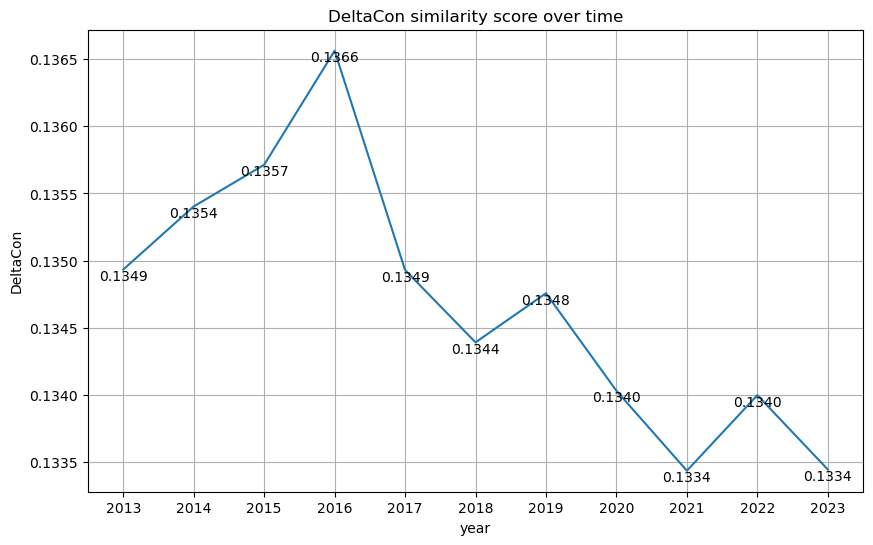

In [8]:
#plot the "DeltaCon" column based on different years
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='year', y='DeltaCon')

# plot the grid in the graph
plt.grid()
plt.title('DeltaCon similarity score over time')
# for each point in the line graph, add a text to show the value
for i, row in results.iterrows():
    plt.text(row['year'], row['DeltaCon'], f"{row['DeltaCon']:.4f}", ha='center', va='top')
# set the x-tick to be the year from 2013 to 2023 for each one year
plt.xticks(range(2013, 2024))
plt.show()


In [9]:
# The main function to compute bidirectional distance
def compute_bidirectional_distance(G_road, G_eco, partition_road_list, partition_eco_list, method="modularity"):
    if method == "modularity":
        F_road_road = modularity(G_road, partition_road_list)
        F_road_eco = modularity(G_road, partition_eco_list)
        F_eco_road = modularity(G_eco, partition_road_list)
        F_eco_eco = modularity(G_eco, partition_eco_list)
    else:
        raise ValueError("Unknown method: {}".format(method))
    
    d_road_eco = 1 + (F_eco_road / F_road_road)
    d_eco_road = 1 + (F_road_eco / F_eco_eco)
    
    return d_road_eco, d_eco_road, F_road_road, F_road_eco, F_eco_road, F_eco_eco

# Define the function to compute the bidirectional distance
def bidir_distance(G_road, G_eco, partition_road, partition_eco, method="modularity"):
    d_road_eco, d_eco_road, F_road_road, F_road_eco, F_eco_road, F_eco_eco = compute_bidirectional_distance(G_road, G_eco, partition_road, partition_eco, method)
    return ((d_road_eco, d_eco_road), (F_road_road, F_road_eco, F_eco_road, F_eco_eco))


C:\Users\SBH\AppData\Local\Temp\ipykernel_32068\1064821855.py:165: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\SBH\AppData\Local\Temp\ipykernel_32068\1064821855.py:165: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\SBH\AppData\Local\Temp\ipykernel_32068\1064821855.py:165: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\SBH\AppData\Local\Temp\ipykernel_32068\1064821855.py:165: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before th

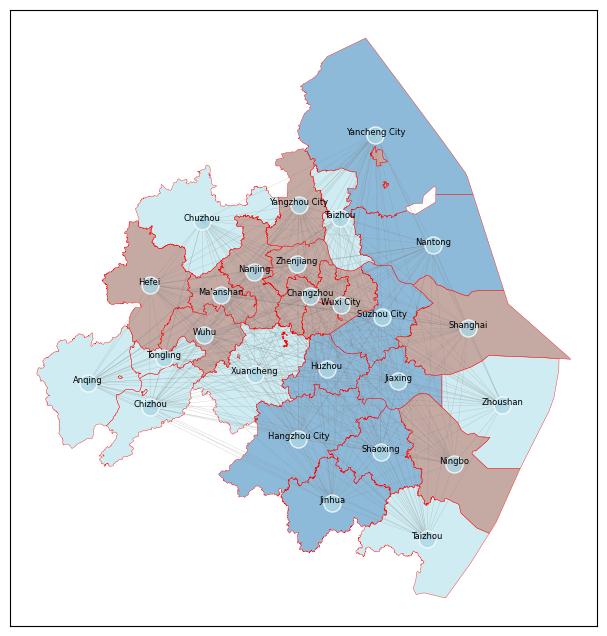

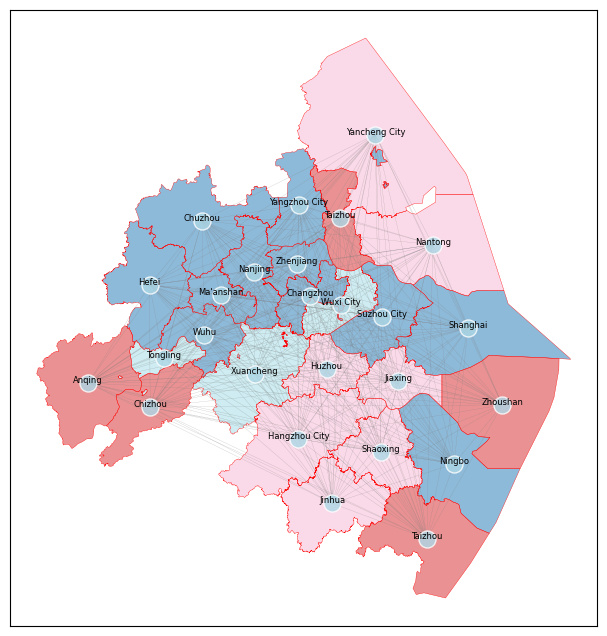

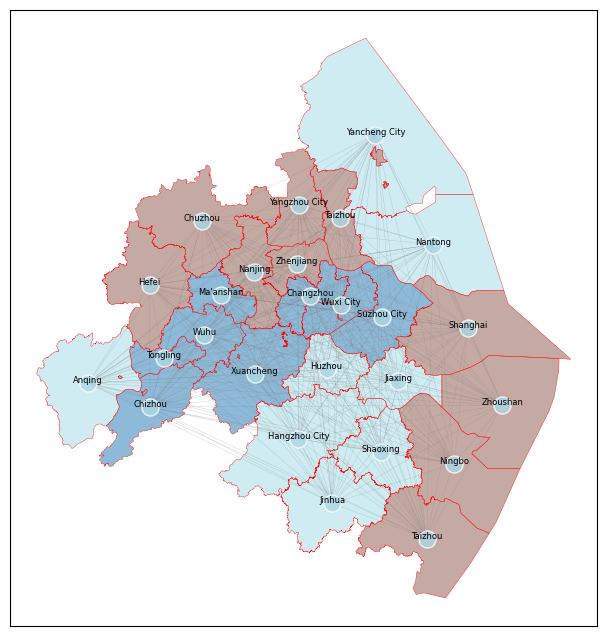

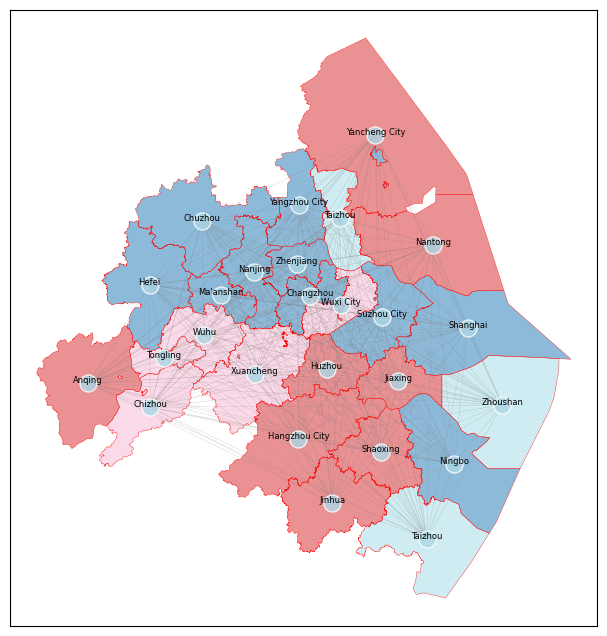

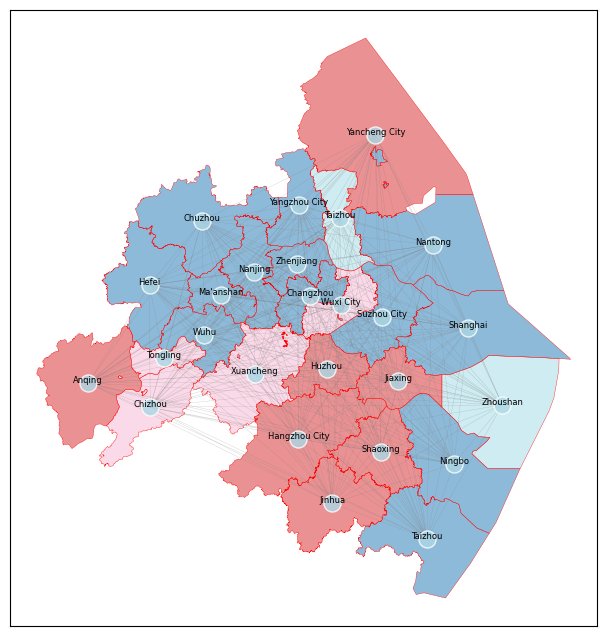

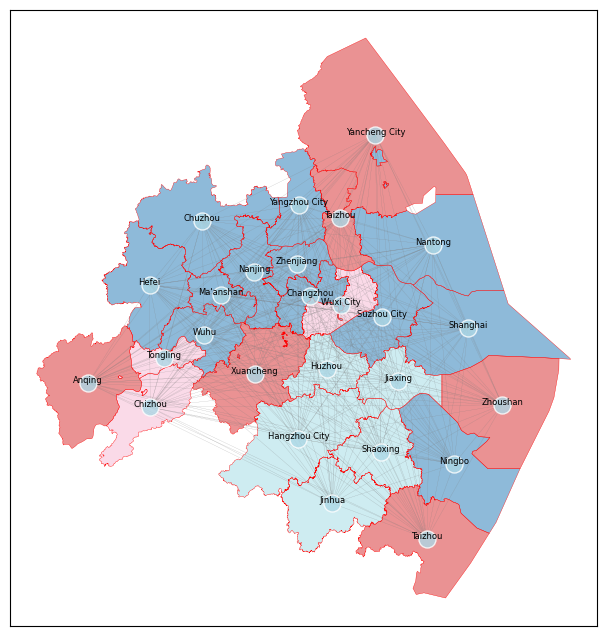

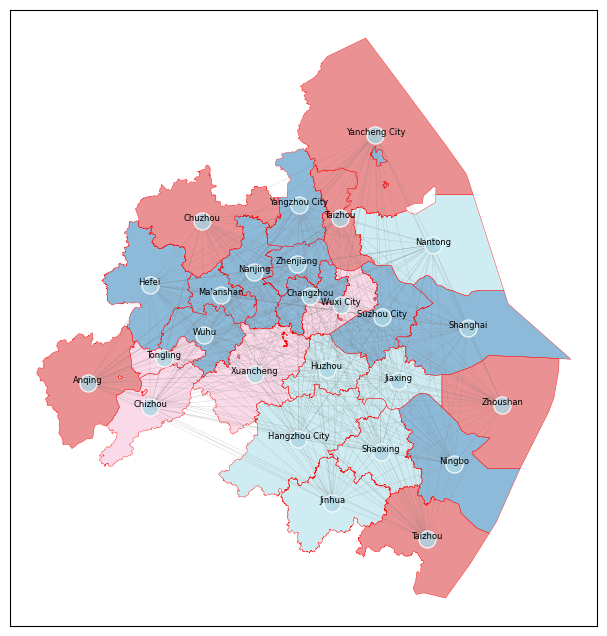

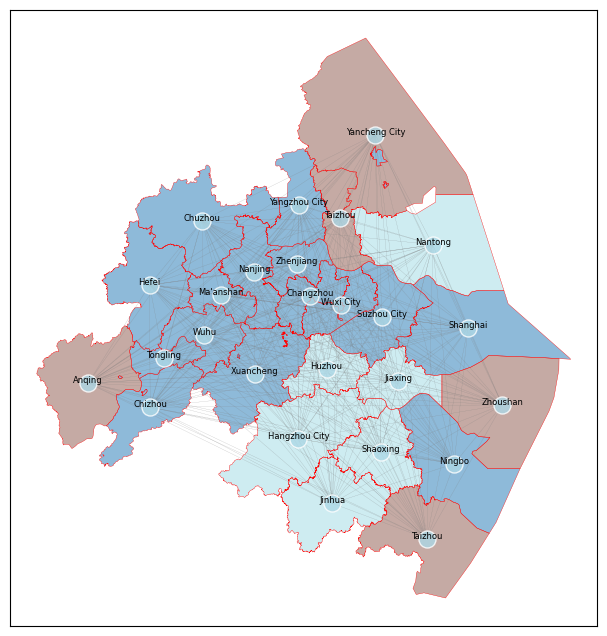

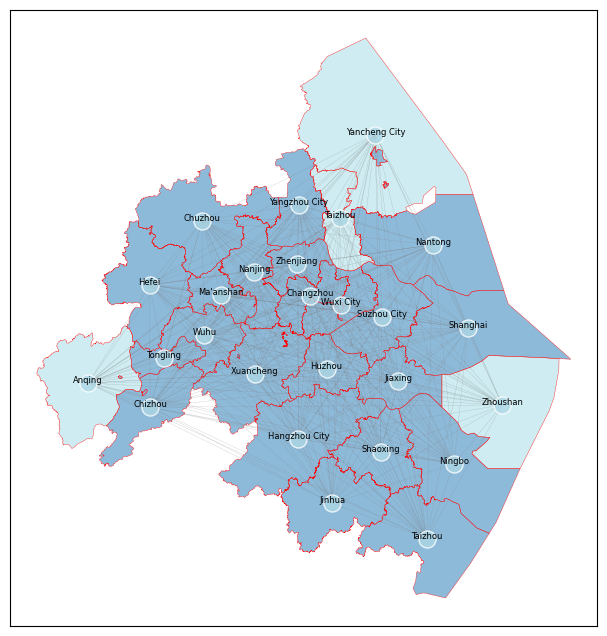

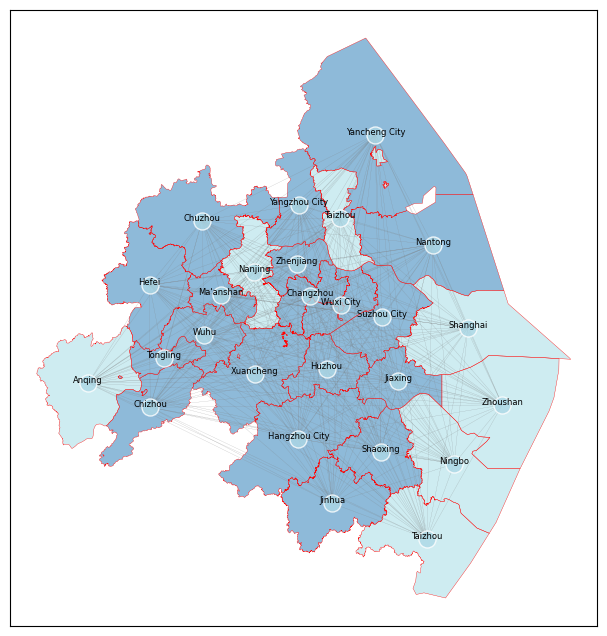

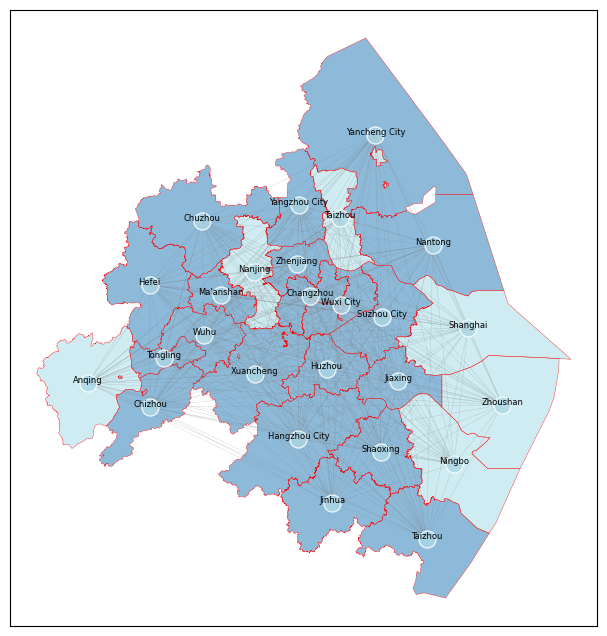

In [10]:
for year in range(2013, 2024):

    # import the BEA code dataset
    BEA = pd.read_csv('Data/python/BEAcode.csv')
    # remove all the NA columns in the dataset
    BEA = BEA.dropna(axis=1, how='all')

    # import the CN code dataset
    CN = pd.read_csv('Data/python/CNcode.csv')
    # remove all the NA columns in the dataset
    CN = CN.dropna(axis=1, how='all')
    # remove all the NA rows in the dataset
    CN = CN.dropna(axis=0, how='all')
    # change the CN_code column to integer
    CN['CN_code'] = CN['CN_code'].astype(int)

    # import the concordance dataset
    concordance = pd.read_csv('Data/python/Concordance.csv')
    # remove all the NA columns in the dataset
    concordance = concordance.dropna(axis=1, how='all')
    # remove all the NA rows in the dataset
    concordance = concordance.dropna(axis=0, how='all')

    # import the matrix dataset, and set the first column as the index
    matrix = pd.read_csv('Data/python/IOMatrix.csv', index_col=0)
    # fill all the NA values with 0
    matrix = matrix.fillna(0)
    # convert all the values in the matrix to float
    matrix = matrix.astype(float)
    # for each value in the matrix, divide it by the last column's value of this row , last column is 'total'
    matrix = matrix.div(matrix['total'], axis=0)
    # drop the last column of the matrix
    matrix = matrix.drop('total', axis=1)

    # c reate a 23*23 matrix to store the summary results
    CN_codelist = concordance['concordance_CN_code'].unique()
    result_matrix = pd.DataFrame(np.zeros((len(CN_codelist), len(CN_codelist))), 
                                index=CN_codelist, columns=CN_codelist)


    # delete all the commas in the matrix so as to convert all values to float
    matrix = matrix.replace(',', '', regex=True)
    # convert all the values in the matrix to float
    matrix = matrix.astype(float)

    for CN_code_i in CN_codelist:
        for CN_code_j in CN_codelist:
            BEA_code_i = concordance[concordance['concordance_CN_code'] == CN_code_i]['IO_code_BEA'].values[0]
            BEA_code_j = concordance[concordance['concordance_CN_code'] == CN_code_j]['IO_code_BEA'].values[0]
            result_matrix.loc[CN_code_i, CN_code_j] = matrix.loc[BEA_code_i, BEA_code_j].sum().sum()

    path = f'Data/python/CityIndustry/CityIndustry{year}.csv'
    city_GDP = pd.read_csv(path, index_col=0,header=0)
    # convert all the values in the city_GDP to float
    city_GDP = city_GDP.astype(float)
    # and fill all the NA values with 0
    city_GDP = city_GDP.fillna(0)
    # reindex  result_matrix 's index based on city's index
    result_matrix_reindex = result_matrix.reindex(city_GDP.index)
    #  reorder  result_matrix 's columns based on city's index
    result_matrix_reindex = result_matrix_reindex.reindex(columns=city_GDP.index)
    # normalize the result matrix by each column?
    result_matrix_reindex_norm = result_matrix_reindex.reindex(columns=city_GDP.index)


    # normalize the city_GDP by each row
    city_GDP_norm_row = city_GDP.div(city_GDP.sum(axis=1), axis=0)
    city_GDP_norm_column = city_GDP.div(city_GDP.sum(axis=0), axis=1)
    # take the log of the city GDP matrix
    city_GDP_all_log = np.log(city_GDP + 1)

    # left multiply the result matrix with the city matrix to get the demand matrix from each city's GDP to each industry
    # this step, we could get how much demand each city have towards each industry in order to get their production
    Demand_city_matrix_all = result_matrix_reindex_norm.dot(city_GDP)

    # normalize the demand matrix by each row and column
    Demand_norm_row = Demand_city_matrix_all.div(Demand_city_matrix_all.sum(axis=1), axis=0)
    Demand_norm_column = Demand_city_matrix_all.div(Demand_city_matrix_all.sum(axis=0), axis=1)
    # take the log of the demand matrix
    Demand_city_matrix_all_log = np.log(Demand_city_matrix_all+1)

    # calculate the sum of each row in the city_GDP and save as an dictionary with index as the key
    Provide_city_matrix_dict = city_GDP.sum(axis=1).to_dict()
    Provide_city_matrix_sum = city_GDP.sum(axis=1)
    Demand_city_sum_dict = Demand_city_matrix_all.sum(axis=1).to_dict()
    Demand_city_sum = Demand_city_matrix_all.sum(axis=1)


    # create a 26*26 matrix to store the dependency relationship between cities
    city_list = city_GDP.columns

    # create an empty city_dependency_matrix and set the data type to object
    city_weighted_dependency_matrix = pd.DataFrame(index=city_list, columns=city_list, dtype=object)

    # initialize each cell in the DataFrame to an empty list
    for i in city_list:
        for j in city_list:
            city_weighted_dependency_matrix.loc[i, j] = []

    # calculate the proportion where city j's GDP contributes to city i's demand, means for each industry, how much will city i depend on city j
    # and for each city pair, sum the weighted dependency for each industry
    for i in city_list:
        for j in city_list:
            temp_dependency = city_GDP_norm_row.loc[:,j] * Demand_norm_row.loc[:, i] * Demand_city_matrix_all.loc[:, i] * city_GDP_norm_column.loc[:,i]
            temp_dependency = temp_dependency.fillna(0)
            # fill the infinities with the maximum value in the temp_dependency
            temp_dependency = temp_dependency.replace([np.inf, -np.inf], 0)
            #take the mean value of the temp_dependency as the dependency value
            depend_value = temp_dependency.sum()
            #depend_value = temp_dependency.sum()
            city_weighted_dependency_matrix.loc[i, j] = depend_value

    city_weighted_dependency_matrix = city_weighted_dependency_matrix.apply(pd.to_numeric, errors='coerce')
    city_weighted_dependency_matrix_norm = np.log(city_weighted_dependency_matrix + 1)
    
    # convert the city_weighted_dependency_matrix to a numpy array
    city_weighted_dependency_matrix_array = city_weighted_dependency_matrix_norm.to_numpy()
    # calculate the mean and standard deviation of the array
    mean_val = city_weighted_dependency_matrix_array.mean()
    std_val = city_weighted_dependency_matrix_array.std()
    # 进行 Z-score 归一化
    city_weighted_dependency_matrix_norm = (city_weighted_dependency_matrix_norm - mean_val) / std_val
    # take the exponential of the normalized matrix
    city_weighted_dependency_matrix_norm = np.exp(city_weighted_dependency_matrix_norm)
    

    #download the city's coordinates from the OpenStreetMap
    # construct the city'list for its specific name in OSM
    city_namelist_OSM = ['Suzhou City, Jiangsu, China','Yangzhou City, Jiangsu, China','Anqing, Anhui, China','Changzhou, Jiangsu, China', 'Chizhou, Anhui, China',
                    '滁州市','Hangzhou City, Zhejiang, China', 'Hefei, Anhui, China','Huzhou, Zhejiang, China','Jiaxing, Zhejiang, China',
                    'Jinhua, Zhejiang, China',"Ma'anshan, Anhui, China", 'Nanjing, Jiangsu, China','Nantong, Jiangsu, China','Ningbo, Zhejiang, China',
                    'Shaoxing, Zhejiang, China','Taizhou, Zhejiang, China','Taizhou, Jiangsu, China','Tongling, Anhui, China','Wuxi City, Jiangsu, China',
                    'Wuhu, Anhui, China','Xuancheng, Anhui, China','Yancheng City, Jiangsu, China','Zhenjiang, Jiangsu, China','Zhoushan, Zhejiang, China','Shanghai, China']
    city_namelist_OSM_en = ['Suzhou City, Jiangsu, China','Yangzhou City, Jiangsu, China','Anqing, Anhui, China','Changzhou, Jiangsu, China', 'Chizhou, Anhui, China',
                    'Chuzhou, Anhui, China','Hangzhou City, Zhejiang, China', 'Hefei, Anhui, China','Huzhou, Zhejiang, China','Jiaxing, Zhejiang, China',
                    'Jinhua, Zhejiang, China',"Ma'anshan, Anhui, China", 'Nanjing, Jiangsu, China','Nantong, Jiangsu, China','Ningbo, Zhejiang, China',
                    'Shaoxing, Zhejiang, China','Taizhou, Zhejiang, China','Taizhou, Jiangsu, China','Tongling, Anhui, China','Wuxi City, Jiangsu, China',
                    'Wuhu, Anhui, China','Xuancheng, Anhui, China','Yancheng City, Jiangsu, China','Zhenjiang, Jiangsu, China','Zhoushan, Zhejiang, China','Shanghai, China']

    # download each city's osmid and save it into a list
    city_osmid = []

    for city_name in city_namelist_OSM:
        try:
            # get the city's geographic data
            gdf = ox.geocode_to_gdf(city_name)
            city_osmid.append(gdf.osm_id.iloc[0])
        except Exception as e:
            print(f"Error retrieving data for {city_name}: {e}")


    # download each city's boundary data and center's coordinates data
    city_centers = {}

    # Iterate over the list of cities to get the boundary and center coordinates of each city
    for i in range(len(city_osmid)):
        try:
            # get the city's geographic data
            gdf = ox.geocode_to_gdf(f"R{city_osmid[i]}", by_osmid=True)
            
            # convert the geographic data to the Web Mercator projection
            gdf_projected = gdf.to_crs(epsg=4326)
            
            # get the center of the city coordinates
            center = gdf_projected.geometry.centroid.iloc[0]
            
            # save the city's center coordinates to a dict
            city_centers[city_namelist_OSM_en[i]] = (center.x, center.y)
            
    
        except Exception as e:
            print(f"Error retrieving data for {city_namelist_OSM_en[i]}: {e}")

    # read the city boundary shapefile
    city_boundary = gpd.read_file('Data/python/Area_boundary.shp')

    # change the index and columns name of combined_dependency_matrix into 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25, 
    # and save it into a new DataFrame called 'edge_matrix'
    edge_matrix = city_weighted_dependency_matrix_norm.copy()
    edge_matrix.index = range(26)
    edge_matrix.columns = range(26)

    # set the diagonal elements of the distance matrix to 0
    np.fill_diagonal(edge_matrix.values, 0)

    Transition_matrix = edge_matrix.copy()
    # normalize the Transition_matrix by each column
    Transition_matrix = Transition_matrix.div(Transition_matrix.sum(axis=0), axis=1)
    # normalize the Transition_matrix by each row
    Transition_matrix = Transition_matrix.div(Transition_matrix.sum(axis=1), axis=0)

    Transition_matrix = Transition_matrix * 100

    #Transition_matrix = (Transition_matrix + Transition_matrix.T) / 2
    #Transition_matrix = np.exp(Transition_matrix)
    Transition_matrix = Transition_matrix.apply(pd.to_numeric)

    # calculate the mean and standard deviation of the Transition_matrix
    mean_val = Transition_matrix.mean().mean()
    std_val = Transition_matrix.std().std()
    # take the z-score noramlization of the Transition_matrix
    Transition_matrix = (Transition_matrix - mean_val) / std_val
    # take the exponential of the z-score normalized matrix
    Transition_matrix = Transition_matrix / 10
    Transition_matrix = np.exp(Transition_matrix)



    # create the raw undirected graph
    G_raw = nx.DiGraph()

    # add the nodes to the network
    for city_name, coords in city_centers.items():
        G_raw.add_node(city_name, pos=coords)


    # add the edges and weights to the network
    for i, city1 in enumerate(city_namelist_OSM_en):
        for j, city2 in enumerate(city_namelist_OSM_en):
            if i != j: 
                # check the weight of the edge between city1 and city2, if it is 0
                # then do not add the edge to the network
                weight_ij = Transition_matrix.iloc[i, j]
                weight_ji = Transition_matrix.iloc[j, i]
                if weight_ij != 0:
                    G_raw.add_edge(city1, city2, weight=weight_ij)

    # 手动设置图的 CRS 属性
    G_raw.graph['crs'] = 'EPSG:4326'

    # run the community detection to the graph G
    communities_GMC = nx.community.greedy_modularity_communities(G_raw, weight='weight', resolution=1.0)

    # save the communities to the G_raw graph, as a attribute for each node
    for i, community in enumerate(communities_GMC):
        for node in community:
            G_raw.nodes[node]['community_GreedyModularity'] = i

    # create a dataframe based on the communities_GMC, the columns will be the communities_id, which values are 0, 1, 2, 3, 4,  or 5
    # and the elements in the same frozenset will share the same value for the community_id, from 0 to 5
    community_df = pd.DataFrame(index=city_namelist_OSM_en, columns=['community_GMC_id_8'])
    for i, community in enumerate(communities_GMC):
        for node in community:
            community_df.loc[node, 'community_GMC_id_8'] = i

    # add the community id to the partition_results dataframe, to the column=year
    for city_name in city_namelist_OSM_en:
        partition_results.loc[city_name, year] = community_df.loc[city_name, 'community_GMC_id_8']





    city_boundary = city_boundary.merge(community_df[['community_GMC_id_8']], left_on='display_na', right_index=True, how='left')

    # 生成颜色映射
    unique_communities = community_df['community_GMC_id_8'].unique()
    colors = plt.cm.get_cmap('tab20', len(unique_communities))
    community_color_map = {community: colors(i) for i, community in enumerate(unique_communities)}

    # 创建图形
    fig, ax = plt.subplots(figsize=(12, 8))

    # 填充边界颜色
    for community in unique_communities:
        boundary_community = city_boundary[city_boundary['community_GMC_id_8'] == community]
        boundary_community.plot(ax=ax, facecolor=community_color_map[community], alpha=0.5, edgecolor='none')

    # Plot the boundary outline
    city_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=0.25, alpha=1)

    # Label the city name, set the font size to 6
    city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)

    # 获取节点位置
    pos = nx.get_node_attributes(G_raw, 'pos')

    # 绘制节点
    nx.draw_networkx_nodes(G_raw, pos, ax=ax, node_size=150, node_color='lightblue', edgecolors='white', alpha=0.8)

    # 绘制边，使用宽度来显示边的权重
    nx.draw_networkx_edges(G_raw, pos, ax=ax, edge_color='gray', width=0.1, arrows=False, alpha=0.5)
    # save the figure as a image png file
    save_filename = f'Results/GMC/Community_GMC{year}.png'
    plt.savefig(save_filename, dpi=300)
    #plt.show()
    city_boundary_df = city_boundary[['place_id', 'display_na', 'name', 'osm_id', 'community_GMC_id_8']]
    # save the city_boundary_df as a csv file
    filename_eco = f'Data/python/Partition_eco{year}.csv'
    city_boundary_df.to_csv(filename_eco, index=False)
    
    # load the data
    Partition_eco = pd.read_csv(filename_eco)
    Partition_road = pd.read_csv('data/python/Partition_road.csv')
    # merge two dataframes into one, by the column'display_na' from Partition_eco and column 'city_name' Partition_road
    Partition = pd.merge(Partition_eco, Partition_road, left_on='display_na', right_on='city_name')
    # drop the column 'city_name'
    Partition = Partition.drop(columns=['city_name'])



    # load the graph from graphml file
    G_road = nx.read_graphml('data/python/Spatial_network.graphml')
    # convert the 'pos' attribute of the nodes from string to tuple, first need to delete the "(" and ")" in the string, and then split the string by ","
    def pos_str_to_tuple(G):
        for node in G.nodes:
            G.nodes[node]['pos'] = tuple(map(float, G.nodes[node]['pos'][1:-1].split(',')))
        return G
    G_road = pos_str_to_tuple(G_road)

    eco_com_list = Partition.columns[4:7].tolist()
    road_com_list = Partition.columns[8:9].tolist()

    # convert the partition results in DataFrame to dictionary
    partition_eco = Partition.set_index('display_na')['community_GMC_id_8'].to_dict()
    partition_road = Partition.set_index('display_na')['community_id3'].to_dict()
    #convert the partition_road to a list of lists, where each list contains the nodes in the same community
    partition_road_list = []
    for i in range(0, len(set(partition_road.values()))):
        partition_road_list.append([key for key, value in partition_road.items() if value == i])

    partition_eco_list = []
    for i in range(0, len(set(partition_eco.values()))):
        partition_eco_list.append([key for key, value in partition_eco.items() if value == i])


    F_road_road = modularity(G_road, partition_road_list) + 0.1
    F_road_eco = modularity(G_road, partition_eco_list) + 0.1
    F_eco_road = modularity(G_raw, partition_road_list) + 0.1
    F_eco_eco = modularity(G_raw, partition_eco_list) + 0.1
    d_road_eco = 1 - (F_road_eco / F_road_road)
    d_eco_road = 1 - (F_eco_road / F_eco_eco)


    # 初始化用于累加随机打乱后的计算结果的变量
    d_road_eco_sum = 0
    d_eco_road_sum = 0
    F_road_eco_sum = 0
    F_eco_eco_sum = 0
    F_road_road_sum = 0
    F_eco_road_sum = 0

    for _ in range(1000):  # 进行10次随机打乱
        # 对原始网络的边进行打乱
        G_control = G_raw.copy()
        # delete all the edges in the G_control
        G_control.remove_edges_from(list(G_control.edges))
        # generate a new transition matrix by shuffling the original transition matrix, but the diagonal elements are still 0
        Transition_matrix_control = Transition_matrix.copy()

        # Shuffle the rows and then the columns
        shuffled_indices = np.random.permutation(Transition_matrix_control.index)
        Transition_matrix_control = Transition_matrix_control.reindex(index=shuffled_indices)
        Transition_matrix_control = Transition_matrix_control.reindex(columns=shuffled_indices)
        # add the edges and weights to the network
        for i, city1 in enumerate(city_namelist_OSM_en):
            for j, city2 in enumerate(city_namelist_OSM_en):
                if i != j: 
                    # check the weight of the edge between city1 and city2, if it is 0
                    # then do not add the edge to the network
                    weight_ij = Transition_matrix_control.iloc[i, j]
                    weight_ji = Transition_matrix_control.iloc[j, i]
                    if weight_ij != 0:
                        G_control.add_edge(city1, city2, weight=weight_ij)



        # 对打乱后的网络进行社区检测
        communities_GMC_control = nx.community.greedy_modularity_communities(G_control, weight='weight', resolution=1.0)

        # 将社区分配到打乱后的网络
        community_df_control = pd.DataFrame(index=city_namelist_OSM_en, columns=['community_GMC_id_8'])
        for i, community in enumerate(communities_GMC_control):
            for node in community:
                community_df_control.loc[node, 'community_GMC_id_8'] = i

        # 计算打乱后的网络的模块度指标
        partition_eco_control = community_df_control['community_GMC_id_8'].to_dict()
        partition_eco_control_list = [[key for key, value in partition_eco_control.items() if value == i] for i in range(len(set(partition_eco_control.values())))]

        F_eco_eco_control = modularity(G_control, partition_eco_control_list) + 0.1
        F_road_eco_control = modularity(G_road, partition_eco_control_list) + 0.1
        F_road_road_control = modularity(G_road, partition_road_list) + 0.1
        F_eco_road_control = modularity(G_control, partition_road_list) + 0.1
        d_road_eco_control = 1 - (F_road_eco_control / F_road_road)
        d_eco_road_control = 1 - (F_eco_road_control / F_eco_eco_control)

        # 累加结果
        d_road_eco_sum += d_road_eco_control
        d_eco_road_sum += d_eco_road_control
        F_road_road_sum += F_road_road_control
        F_eco_road_sum += F_eco_road_control
        F_road_eco_sum += F_road_eco_control
        F_eco_eco_sum += F_eco_eco_control

    # 计算平均值
    d_road_eco_avg = d_road_eco_sum / 1000
    d_eco_road_avg = d_eco_road_sum / 1000
    F_road_eco_avg = F_road_eco_sum / 1000
    F_eco_eco_avg = F_eco_eco_sum / 1000
    F_road_road_avg = F_road_road_sum / 1000
    F_eco_road_avg = F_eco_road_sum / 1000

    # fill the results dataframe with the results
    results.loc[results['year'] == year, ['d_road_eco', 'd_eco_road', 'F_road_road', 'F_road_eco', 'F_eco_road', 'F_eco_eco']] = [d_road_eco, d_eco_road, F_road_road, F_road_eco, F_eco_road, F_eco_eco]

    # 将平均后的控制组结果保存到结果数据框
    results.loc[results['year'] == year, ['d_road_eco_control', 'd_eco_road_control', 'F_road_road_control', 'F_road_eco_control', 'F_eco_road_control', 'F_eco_eco_control']] = [d_road_eco_avg, d_eco_road_avg, F_road_road_avg, F_road_eco_avg, F_eco_road_avg, F_eco_eco_avg]

In [11]:
results

year     measure d_road_eco d_eco_road F_road_road F_road_eco F_eco_road  \
0   2013  Modularity   0.570609   0.392457     0.30365   0.130385   0.107289   
1   2014  Modularity   0.594704   0.463817     0.30365   0.123068   0.091842   
2   2015  Modularity    0.57893   0.411625     0.30365   0.127858   0.095343   
3   2016  Modularity   0.594535   0.421589     0.30365   0.123119   0.098196   
4   2017  Modularity   0.605005   0.434327     0.30365    0.11994   0.094689   
5   2018  Modularity   0.569905   0.459242     0.30365   0.130598   0.083848   
6   2019  Modularity   0.619243   0.478022     0.30365   0.115617   0.085801   
7   2020  Modularity   0.526987   0.454991     0.30365   0.143631   0.079349   
8   2021  Modularity   0.692487   0.411247     0.30365   0.093376   0.073387   
9   2022  Modularity   0.722669   0.472695     0.30365   0.084211   0.077326   
10  2023  Modularity   0.744274   0.482077     0.30365   0.077651   0.075104   

   F_eco_eco d_road_eco_control d_eco_road_control F_road_road_control  \
0   0.176595           0.765673           0.586683             0.30365   
1   0.171289           0.770077           0.575404             0.30365   
2   0.162045           0.764813           0.542021             0.30365   
3   0.169769           0.774993           0.573043             0.30365   
4   0.167392           0.766919           0.562016             0.30365   
5   0.155057           0.769331           0.527162             0.30365   
6   0.164377           0.776087           0.556632             0.30365   
7   0.145592           0.752853           0.494719             0.30365   
8   0.124649           0.707187            0.41206             0.30365   
9   0.146644           0.730268           0.501942             0.30365   
10   0.14501           0.721389            0.49188             0.30365   

   F_road_eco_control F_eco_road_control F_eco_eco_control  DeltaCon  \
0            0.071154            0.07299          0.176595  0.134933   
1            0.069816           0.072729          0.171289  0.135403   
2            0.071415           0.074213          0.162045  0.135713   
3            0.068324           0.072484          0.169769  0.136563   
4            0.070775           0.073315          0.167392   0.13493   
5            0.070043           0.073317          0.155057  0.134391   
6            0.067991           0.072879          0.164377  0.134757   
7            0.075046           0.073565          0.145592   0.13403   
8            0.088913           0.073286          0.124649  0.133435   
9            0.081904           0.073037          0.146644  0.133998   
10             0.0846           0.073682           0.14501  0.133444   

   DeltaCon_control  
0          0.133519  
1          0.133548  
2          0.133669  
3          0.133608  
4          0.133614  
5          0.133919  
6          0.133826  
7          0.133788  
8          0.133663  
9          0.133646  
10          0.13352

In [12]:
results.to_csv('Results/Modularity_bidir_results_new.csv', index=False)

In [13]:
partition_results

2013  2014  2015  2016  2017  2018  2019  \
Anqing, Anhui, China               2     2     2     1     1     1     2   
Changzhou, Jiangsu, China          0     0     1     0     0     0     0   
Chizhou, Anhui, China              2     2     1     2     2     3     3   
Chuzhou, Anhui, China              2     0     0     0     0     0     2   
Hangzhou City, Zhejiang, China     1     1     2     1     1     2     1   
Hefei, Anhui, China                0     0     0     0     0     0     0   
Huzhou, Zhejiang, China            1     1     2     1     1     2     1   
Jiaxing, Zhejiang, China           1     1     2     1     1     2     1   
Jinhua, Zhejiang, China            1     1     2     1     1     2     1   
Ma'anshan, Anhui, China            0     0     1     0     0     0     0   
Nanjing, Jiangsu, China            0     0     0     0     0     0     0   
Nantong, Jiangsu, China            1     1     2     1     0     0     1   
Ningbo, Zhejiang, China            0     0     0     0     0     0     0   
Shanghai, China                    0     0     0     0     0     0     0   
Shaoxing, Zhejiang, China          1     1     2     1     1     2     1   
Suzhou City, Jiangsu, China        1     0     1     0     0     0     0   
Taizhou, Jiangsu, China            2     2     0     3     3     1     2   
Taizhou, Zhejiang, China           2     2     0     3     0     1     2   
Tongling, Anhui, China             2     3     1     2     2     3     3   
Wuhu, Anhui, China                 0     0     1     2     0     0     0   
Wuxi City, Jiangsu, China          0     3     1     2     2     3     3   
Xuancheng, Anhui, China            2     3     1     2     2     1     3   
Yancheng City, Jiangsu, China      1     1     2     1     1     1     2   
Yangzhou City, Jiangsu, China      0     0     0     0     0     0     0   
Zhenjiang, Jiangsu, China          0     0     0     0     0     0     0   
Zhoushan, Zhejiang, China          2     2     0     3     3     1     2   

                                2020  2021  2022  2023  
Anqing, Anhui, China               2     1     1     1  
Changzhou, Jiangsu, China          0     0     0     0  
Chizhou, Anhui, China              0     0     0     0  
Chuzhou, Anhui, China              0     0     0     0  
Hangzhou City, Zhejiang, China     1     0     0     0  
Hefei, Anhui, China                0     0     0     0  
Huzhou, Zhejiang, China            1     0     0     0  
Jiaxing, Zhejiang, China           1     0     0     0  
Jinhua, Zhejiang, China            1     0     0     0  
Ma'anshan, Anhui, China            0     0     0     0  
Nanjing, Jiangsu, China            0     0     1     1  
Nantong, Jiangsu, China            1     0     0     0  
Ningbo, Zhejiang, China            0     0     1     1  
Shanghai, China                    0     0     1     1  
Shaoxing, Zhejiang, China          1     0     0     0  
Suzhou City, Jiangsu, China        0     0     0     0  
Taizhou, Jiangsu, China            2     1     1     1  
Taizhou, Zhejiang, China           2     0     1     0  
Tongling, Anhui, China             0     0     0     0  
Wuhu, Anhui, China                 0     0     0     0  
Wuxi City, Jiangsu, China          0     0     0     0  
Xuancheng, Anhui, China            0     0     0     0  
Yancheng City, Jiangsu, China      2     1     0     0  
Yangzhou City, Jiangsu, China      0     0     0     0  
Zhenjiang, Jiangsu, China          0     0     0     0  
Zhoushan, Zhejiang, China          2     1     1     1

In [14]:
# construct a new network based on the partition results, in the new network, the nodes are index city names
# and the edge weight between two cities is the number of how many times they are in the same community among all the years
G_partition = G_road.copy()

# clear all edges in the network
G_partition.remove_edges_from(list(G_partition.edges))


# add the edges and weights to the network
for i, city1 in enumerate(city_namelist_OSM_en):
    for j, city2 in enumerate(city_namelist_OSM_en):
        if i != j: 
            # check the weight of the edge between city1 and city2, if it is 0
            # then do not add the edge to the network
            weight = sum(partition_results.loc[city1] == partition_results.loc[city2])
            if weight != 0:
                G_partition.add_edge(city1, city2, weight=weight)

# 手动设置图的 CRS 属性
G_partition.graph['crs'] = 'EPSG:4326'



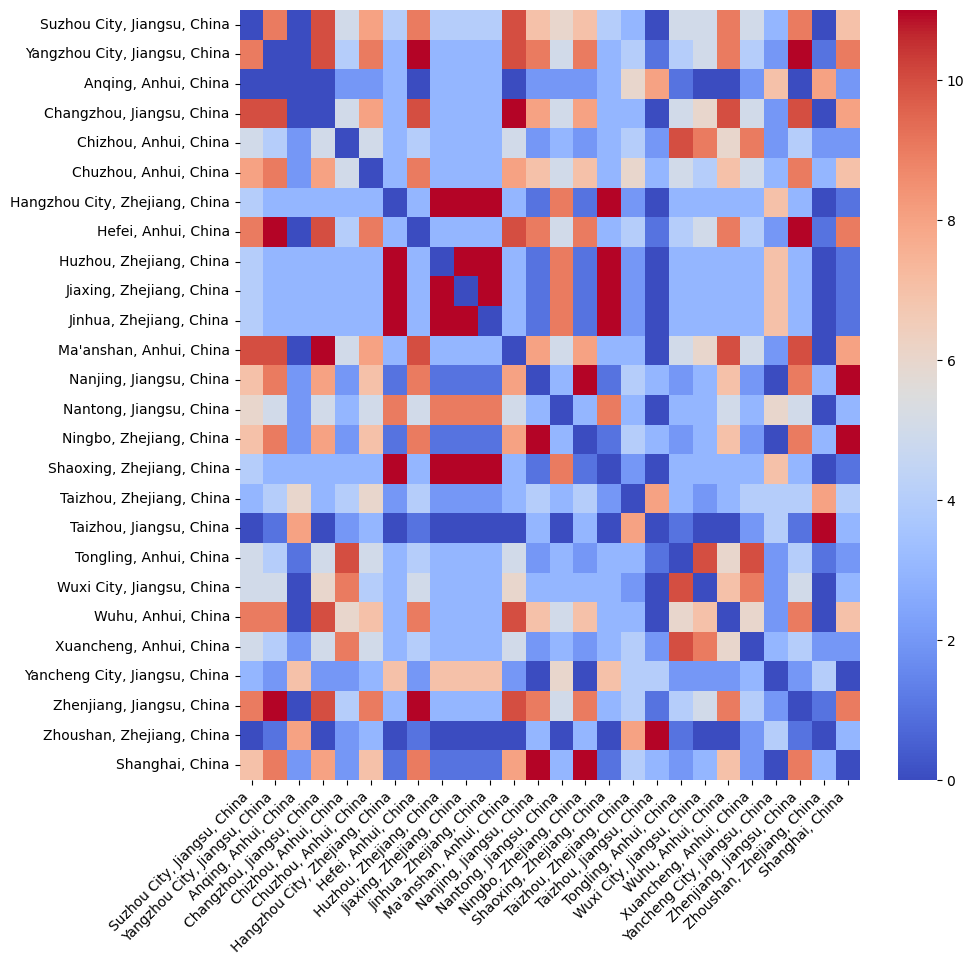

In [15]:
#substract the adjacent matrix from the G_partition network
A = nx.adjacency_matrix(G_partition).todense()
# plot the heatmap of the adjacency matrix, and label the x and y axis with the city names
plt.figure(figsize=(10, 10))
sns.heatmap(A, xticklabels=city_namelist_OSM_en, yticklabels=city_namelist_OSM_en, cmap='coolwarm')
# set the xticks's va to top, and ha to right but offset a little bit
plt.xticks(ha='right', va='top')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


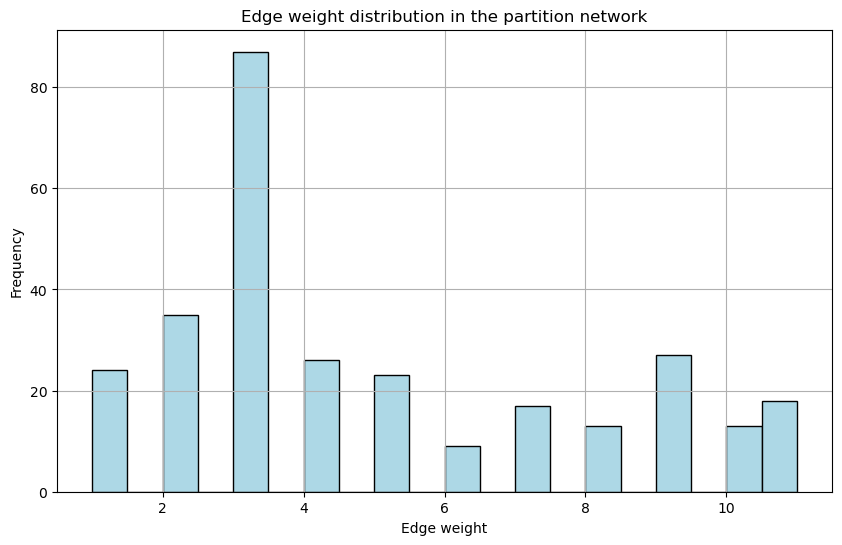

In [16]:
# plot all edge weights in the network as a histogram
plt.figure(figsize=(10, 6))
weights = [data['weight'] for u, v, data in G_partition.edges(data=True)]
plt.hist(weights, bins=20, color='lightblue', edgecolor='black')
plt.xlabel('Edge weight')
plt.ylabel('Frequency')
plt.title('Edge weight distribution in the partition network')
plt.grid()
plt.show()


In [17]:
# calculate each node's degree centrality, including eigenvalue centrality, closeness centrality, betweenness centrality, and degree centrality, edge weight is considered

degree_centrality = nx.degree_centrality(G_partition)
eigenvector_centrality = nx.eigenvector_centrality(G_partition)
closeness_centrality = nx.closeness_centrality(G_partition)
betweenness_centrality = nx.betweenness_centrality(G_partition)
# create a dataframe to store the centrality results
centrality_results = pd.DataFrame([degree_centrality, eigenvector_centrality, closeness_centrality, betweenness_centrality]).T
centrality_results.columns = ['degree_centrality', 'eigenvector_centrality', 'closeness_centrality', 'betweenness_centrality']
centrality_results = centrality_results.sort_values(by='betweenness_centrality', ascending=False)
centrality_results

degree_centrality  eigenvector_centrality  \
Chizhou, Anhui, China                        1.00                0.212216   
Chuzhou, Anhui, China                        1.00                0.212216   
Xuancheng, Anhui, China                      1.00                0.212216   
Tongling, Anhui, China                       1.00                0.212216   
Taizhou, Zhejiang, China                     1.00                0.212216   
Shanghai, China                              0.96                0.204391   
Ningbo, Zhejiang, China                      0.96                0.204391   
Yancheng City, Jiangsu, China                0.88                0.186487   
Nanjing, Jiangsu, China                      0.96                0.204391   
Zhenjiang, Jiangsu, China                    0.96                0.206126   
Hefei, Anhui, China                          0.96                0.206126   
Yangzhou City, Jiangsu, China                0.96                0.206126   
Anqing, Anhui, China                         0.68                0.145141   
Shaoxing, Zhejiang, China                    0.92                0.202129   
Nantong, Jiangsu, China                      0.92                0.202129   
Jinhua, Zhejiang, China                      0.92                0.202129   
Jiaxing, Zhejiang, China                     0.92                0.202129   
Huzhou, Zhejiang, China                      0.92                0.202129   
Hangzhou City, Zhejiang, China               0.92                0.202129   
Taizhou, Jiangsu, China                      0.56                0.120200   
Zhoushan, Zhejiang, China                    0.56                0.120200   
Ma'anshan, Anhui, China                      0.88                0.196039   
Wuxi City, Jiangsu, China                    0.88                0.196039   
Wuhu, Anhui, China                           0.88                0.196039   
Changzhou, Jiangsu, China                    0.88                0.196039   
Suzhou City, Jiangsu, China                  0.88                0.196039   

                                closeness_centrality  betweenness_centrality  
Chizhou, Anhui, China                       1.000000                0.008009  
Chuzhou, Anhui, China                       1.000000                0.008009  
Xuancheng, Anhui, China                     1.000000                0.008009  
Tongling, Anhui, China                      1.000000                0.008009  
Taizhou, Zhejiang, China                    1.000000                0.008009  
Shanghai, China                             0.961538                0.007554  
Ningbo, Zhejiang, China                     0.961538                0.007554  
Yancheng City, Jiangsu, China               0.892857                0.007554  
Nanjing, Jiangsu, China                     0.961538                0.007554  
Zhenjiang, Jiangsu, China                   0.961538                0.006309  
Hefei, Anhui, China                         0.961538                0.006309  
Yangzhou City, Jiangsu, China               0.961538                0.006309  
Anqing, Anhui, China                        0.757576                0.003531  
Shaoxing, Zhejiang, China                   0.925926                0.002154  
Nantong, Jiangsu, China                     0.925926                0.002154  
Jinhua, Zhejiang, China                     0.925926                0.002154  
Jiaxing, Zhejiang, China                    0.925926                0.002154  
Huzhou, Zhejiang, China                     0.925926                0.002154  
Hangzhou City, Zhejiang, China              0.925926                0.002154  
Taizhou, Jiangsu, China                     0.694444                0.001043  
Zhoushan, Zhejiang, China                   0.694444                0.001043  
Ma'anshan, Anhui, China                     0.892857                0.000455  
Wuxi City, Jiangsu, China                   0.892857                0.000455  
Wuhu, Anhui, China                          0.892857    

In [18]:
city_boundary_partition = gpd.read_file('Data/python/Area_boundary.shp')

In [19]:
# merge the centrality results with the city_boundary_partition
city_boundary_partition = city_boundary_partition.merge(centrality_results[['betweenness_centrality']], left_on='display_na', right_index=True, how='left')

In [20]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis

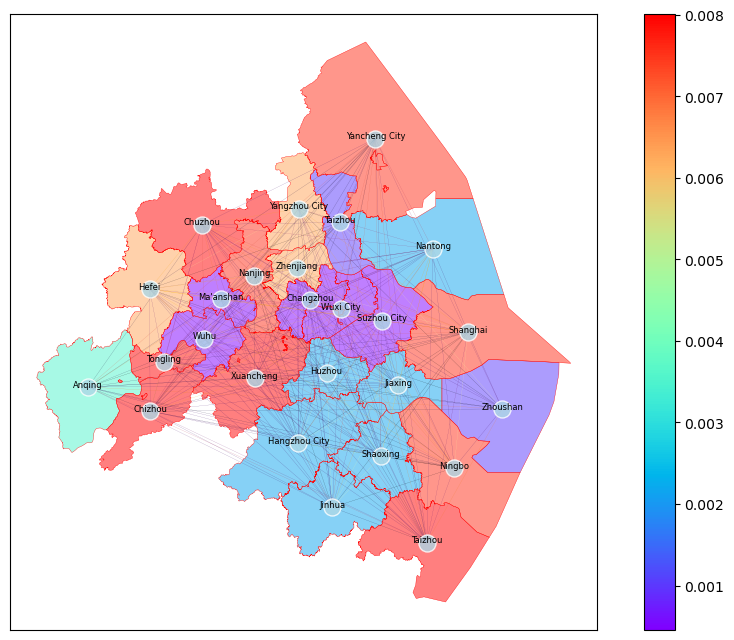

In [21]:
# 创建图形
fig, ax = plt.subplots(figsize=(12, 8))

# plot the boundary of the city, facecolor is based on the betweenness centrality value with 'viridis' cmap
city_boundary_partition.plot(ax=ax, facecolor='lightgray', edgecolor='none', alpha=0.5, column='betweenness_centrality', cmap='rainbow', legend=True)

# Plot the boundary outline
city_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=0.25, alpha=1)

# Label the city name, set the font size to 6
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1)

# 获取节点位置
pos = nx.get_node_attributes(G_raw, 'pos')

# Normalize the weights for the colormap
weights = [data['weight'] for u, v, data in G_partition.edges(data=True)]
norm = Normalize(vmin=min(weights), vmax=max(weights))
# Create a ScalarMappable object with the colormap
sm = ScalarMappable(cmap='inferno', norm=norm)
# Plot the edges with color mapping based on weights
edge_colors = [sm.to_rgba(data['weight']) for u, v, data in G_partition.edges(data=True)]

nx.draw_networkx_edges(G_partition, pos, ax=ax, edge_color=edge_colors, width=0.1, arrows=False, alpha=0.8)

# 绘制节点
nx.draw_networkx_nodes(G_partition, pos, ax=ax, node_size=150, node_color='lightblue', edgecolors='white', alpha=0.8)

plt.show()

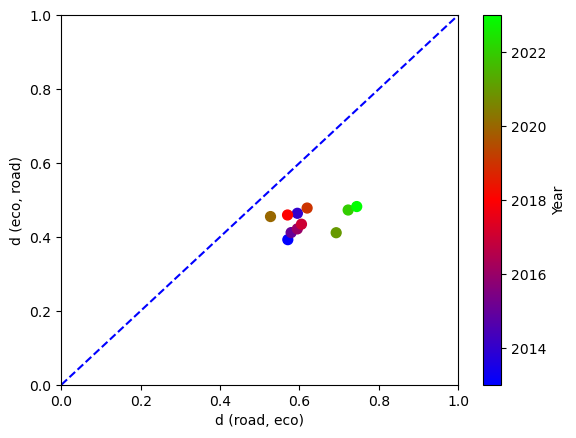

In [22]:
# plot the d_road_eco and d_eco_road column in a scatter plot, and use the color for different eco_commu_method and road_commu_method as legend
fig, ax = plt.subplots()

# set the x and y axis from 0 to 1, and add a diagonal dashed line, color is blue
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.plot([0, 4], [0, 4], linestyle='--', color='blue')

# set the scatter's size to 5
size = 50

# 归一化年份数据到 [0, 1] 范围
norm = plt.Normalize(results['year'].min(), results['year'].max())
cmap = plt.get_cmap('brg')

# 绘制散点图，颜色基于归一化的年份数据
sc = ax.scatter(results['d_road_eco'], results['d_eco_road'], s=size, c=results['year'], cmap=cmap, norm=norm)

# 添加颜色条
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Year')

ax.set_xlabel('d (road, eco)')
ax.set_ylabel('d (eco, road)')
plt.show()

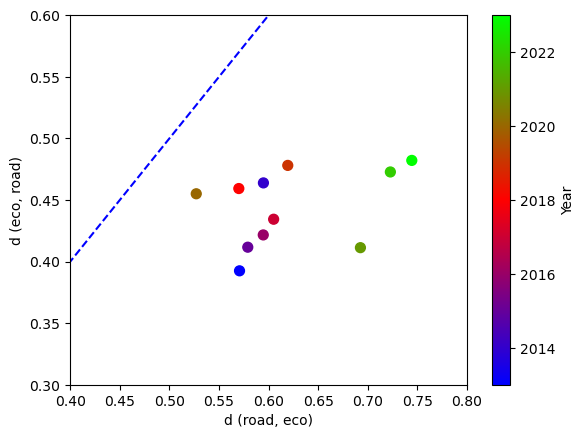

In [23]:
# plot the d_road_eco and d_eco_road column in a scatter plot, and use the color for different eco_commu_method and road_commu_method as legend
fig, ax = plt.subplots()

# set the x and y axis from 0 to 1, and add a diagonal dashed line, color is blue
ax.set_xlim(0.4, 0.8)
ax.set_ylim(0.3, 0.6)
ax.plot([0, 4], [0, 4], linestyle='--', color='blue')

# set the scatter's size to 5
size = 50

# 归一化年份数据到 [0, 1] 范围
norm = plt.Normalize(results['year'].min(), results['year'].max())
cmap = plt.get_cmap('brg')

# 绘制散点图，颜色基于归一化的年份数据
sc = ax.scatter(results['d_road_eco'], results['d_eco_road'], s=size, c=results['year'], cmap=cmap, norm=norm)

# 添加颜色条
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Year')

ax.set_xlabel('d (road, eco)')
ax.set_ylabel('d (eco, road)')
plt.show()

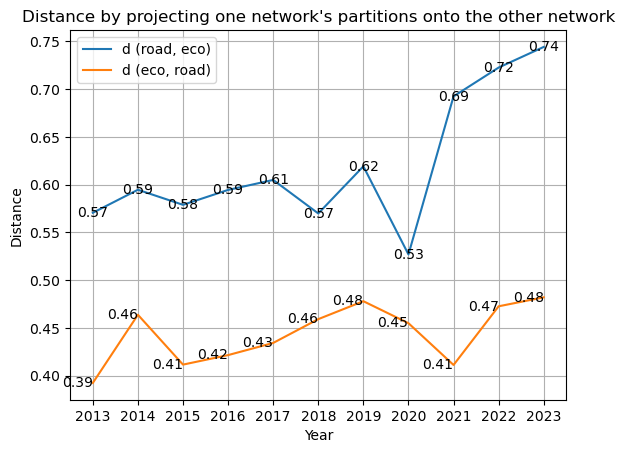

In [24]:
# plot the line graph by using year as the x-axis and the d_road_eco and d_eco_road as the y-axis
fig, ax = plt.subplots()

# plot the d_road_eco and d_eco_road column in a line graph
ax.plot(results['year'], results['d_road_eco'], label='d (road, eco)')
ax.plot(results['year'], results['d_eco_road'], label='d (eco, road)')
ax.set_xlabel('Year')
ax.set_ylabel('Distance')
ax.legend()
# for each point in the line graph, add a text to show the value
for i, row in results.iterrows():
    ax.text(row['year'], row['d_road_eco'], f"{row['d_road_eco']:.2f}", ha='center', va='center')
    ax.text(row['year'], row['d_eco_road'], f"{row['d_eco_road']:.2f}", ha='right', va='center')
# set the title of the graph
plt.title("Distance by projecting one network's partitions onto the other network")
# set the x-tick to be the year from 2013 to 2023 for each one year
plt.xticks(range(2013, 2024))
# plot the grid in the graph
plt.grid()
plt.show()

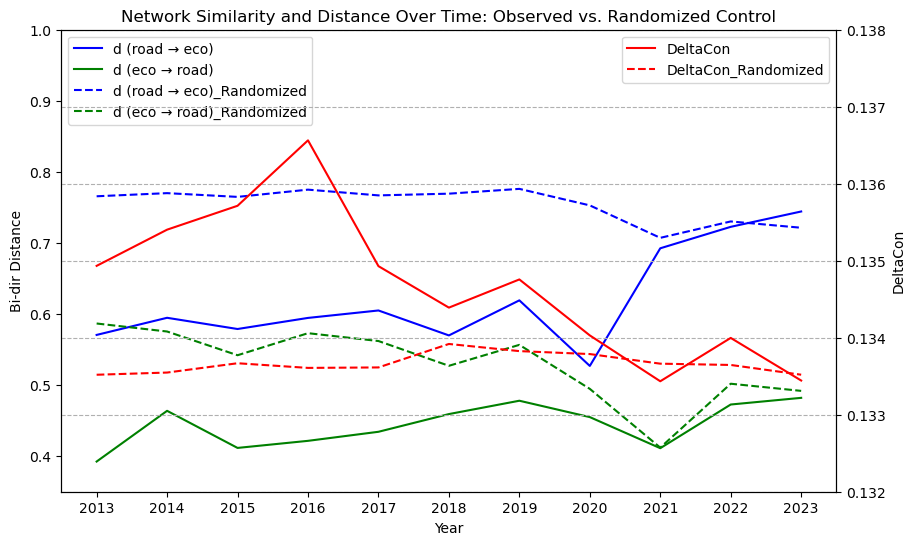

In [25]:
import matplotlib.pyplot as plt

# set the figure size as 10*6

fig, ax1 = plt.subplots(figsize=(10, 6))


# Plot the d_road_eco and d_eco_road columns on the primary y-axis
ax1.plot(results['year'], results['d_road_eco'], label='d (road → eco)', color='blue')
ax1.plot(results['year'], results['d_eco_road'], label='d (eco → road)', color='green')
ax1.plot(results['year'], results['d_road_eco_control'], label='d (road → eco)_Randomized', linestyle='--', color='blue')
ax1.plot(results['year'], results['d_eco_road_control'], label='d (eco → road)_Randomized', linestyle='--', color='green')
ax1.set_xlabel('Year')
ax1.set_ylabel('Bi-dir Distance')
ax1.legend(loc='upper left')

ax1.set_ylim(0.35, 1.0)

# Add text annotations for each point in the d_road_eco and d_eco_road lines

"""
for i, row in results.iterrows():
    ax1.text(row['year'], row['d_road_eco'], f"{row['d_road_eco']:.2f}", ha='right', va='center', color='black')
    ax1.text(row['year'], row['d_eco_road'], f"{row['d_eco_road']:.2f}", ha='right', va='center', color='black')
    ax1.text(row['year'], row['d_road_eco_control'], f"{row['d_road_eco_control']:.2f}", ha='right', va='center', color='black')
    ax1.text(row['year'], row['d_eco_road_control'], f"{row['d_eco_road_control']:.2f}", ha='right', va='center', color='black')
"""

# Create a second y-axis for the DeltaCon data
ax2 = ax1.twinx()
ax2.plot(results['year'], results['DeltaCon'], label='DeltaCon', color='red')
ax2.plot(results['year'], results['DeltaCon_control'], label='DeltaCon_Randomized', linestyle='--', color='red')
ax2.set_ylabel('DeltaCon')

ax2.set_ylim(0.1320, 0.1380)

# Add text annotations for each point in the DeltaCon line
"""
for i, row in results.iterrows():
    ax2.text(row['year'], row['DeltaCon'], f"{row['DeltaCon']:.3f}", ha='left', va='center', color='black')
    ax2.text(row['year'], row['DeltaCon_control'], f"{row['DeltaCon_control']:.3f}", ha='left', va='center', color='black')
"""

# Set the title of the graph
plt.title("Network Similarity and Distance Over Time: Observed vs. Randomized Control")

# Set the x-ticks to be the year from 2013 to 2023 for each one year
plt.xticks(range(2013, 2024))

# Plot the grid in the graph
plt.grid(which='both', linestyle='--')

# Add legends for the second y-axis
ax2.legend(loc='upper right')

# Show the plot
plt.show()


In [26]:
results

year     measure d_road_eco d_eco_road F_road_road F_road_eco F_eco_road  \
0   2013  Modularity   0.570609   0.392457     0.30365   0.130385   0.107289   
1   2014  Modularity   0.594704   0.463817     0.30365   0.123068   0.091842   
2   2015  Modularity    0.57893   0.411625     0.30365   0.127858   0.095343   
3   2016  Modularity   0.594535   0.421589     0.30365   0.123119   0.098196   
4   2017  Modularity   0.605005   0.434327     0.30365    0.11994   0.094689   
5   2018  Modularity   0.569905   0.459242     0.30365   0.130598   0.083848   
6   2019  Modularity   0.619243   0.478022     0.30365   0.115617   0.085801   
7   2020  Modularity   0.526987   0.454991     0.30365   0.143631   0.079349   
8   2021  Modularity   0.692487   0.411247     0.30365   0.093376   0.073387   
9   2022  Modularity   0.722669   0.472695     0.30365   0.084211   0.077326   
10  2023  Modularity   0.744274   0.482077     0.30365   0.077651   0.075104   

   F_eco_eco d_road_eco_control d_eco_road_control F_road_road_control  \
0   0.176595           0.765673           0.586683             0.30365   
1   0.171289           0.770077           0.575404             0.30365   
2   0.162045           0.764813           0.542021             0.30365   
3   0.169769           0.774993           0.573043             0.30365   
4   0.167392           0.766919           0.562016             0.30365   
5   0.155057           0.769331           0.527162             0.30365   
6   0.164377           0.776087           0.556632             0.30365   
7   0.145592           0.752853           0.494719             0.30365   
8   0.124649           0.707187            0.41206             0.30365   
9   0.146644           0.730268           0.501942             0.30365   
10   0.14501           0.721389            0.49188             0.30365   

   F_road_eco_control F_eco_road_control F_eco_eco_control  DeltaCon  \
0            0.071154            0.07299          0.176595  0.134933   
1            0.069816           0.072729          0.171289  0.135403   
2            0.071415           0.074213          0.162045  0.135713   
3            0.068324           0.072484          0.169769  0.136563   
4            0.070775           0.073315          0.167392   0.13493   
5            0.070043           0.073317          0.155057  0.134391   
6            0.067991           0.072879          0.164377  0.134757   
7            0.075046           0.073565          0.145592   0.13403   
8            0.088913           0.073286          0.124649  0.133435   
9            0.081904           0.073037          0.146644  0.133998   
10             0.0846           0.073682           0.14501  0.133444   

   DeltaCon_control  
0          0.133519  
1          0.133548  
2          0.133669  
3          0.133608  
4          0.133614  
5          0.133919  
6          0.133826  
7          0.133788  
8          0.133663  
9          0.133646  
10          0.13352

In [27]:
results['year'] = pd.to_numeric(results['year'], errors='coerce')

In [28]:
# convert all columns to float except "measure" column
results = results.apply(pd.to_numeric, errors='ignore')

C:\Users\SBH\AppData\Local\Temp\ipykernel_32068\406413792.py:2: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



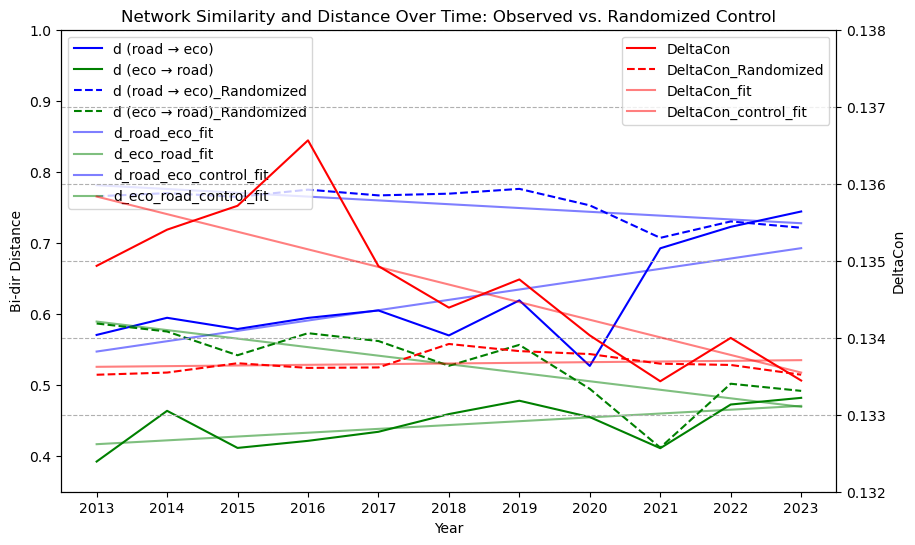

In [29]:

# Set the figure size as 10*6
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the d_road_eco and d_eco_road columns on the primary y-axis
ax1.plot(results['year'], results['d_road_eco'], label='d (road → eco)', color='blue')
ax1.plot(results['year'], results['d_eco_road'], label='d (eco → road)', color='green')
ax1.plot(results['year'], results['d_road_eco_control'], label='d (road → eco)_Randomized', linestyle='--', color='blue')
ax1.plot(results['year'], results['d_eco_road_control'], label='d (eco → road)_Randomized', linestyle='--', color='green')


# Add linear fit lines for each data series on the primary y-axis
for series, color in zip(['d_road_eco', 'd_eco_road', 'd_road_eco_control', 'd_eco_road_control'], ['blue', 'green', 'blue', 'green']):
    coeffs = np.polyfit(results['year'], results[series], 1)  # 1st-degree polynomial (linear fit)
    fit_line = np.poly1d(coeffs)(results['year'])
    ax1.plot(results['year'], fit_line, linestyle='-', color=color, alpha=0.5, label=f'{series}_fit')

ax1.set_xlabel('Year')
ax1.set_ylabel('Bi-dir Distance')
ax1.legend(loc='upper left')
ax1.set_ylim(0.35, 1.0)

# Create a second y-axis for the DeltaCon data
ax2 = ax1.twinx()
ax2.plot(results['year'], results['DeltaCon'], label='DeltaCon', color='red')
ax2.plot(results['year'], results['DeltaCon_control'], label='DeltaCon_Randomized', linestyle='--', color='red')

# Add linear fit lines for each data series on the secondary y-axis
for series, color in zip(['DeltaCon', 'DeltaCon_control'], ['red', 'red']):
    coeffs = np.polyfit(results['year'], results[series], 1)  # 1st-degree polynomial (linear fit)
    fit_line = np.poly1d(coeffs)(results['year'])
    ax2.plot(results['year'], fit_line, linestyle='-', color=color, alpha=0.5, label=f'{series}_fit')

ax2.set_ylabel('DeltaCon')
ax2.set_ylim(0.1320, 0.1380)

# Set the title of the graph
plt.title("Network Similarity and Distance Over Time: Observed vs. Randomized Control")

# Set the x-ticks to be the year from 2013 to 2023 for each one year
plt.xticks(range(2013, 2024))

# Plot the grid in the graph
plt.grid(which='both', linestyle='--')

# Add legends for the second y-axis
ax2.legend(loc='upper right')

# Show the plot
plt.show()

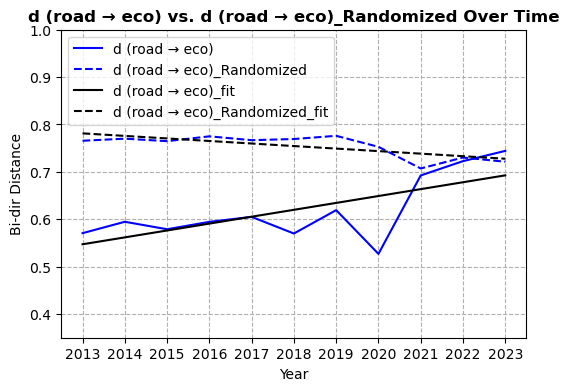

In [41]:
# Set the figure size as 10*6
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot the d_road_eco and d_road_eco_control columns on the primary y-axis
ax1.plot(results['year'], results['d_road_eco'], label='d (road → eco)', color='blue')
ax1.plot(results['year'], results['d_road_eco_control'], label='d (road → eco)_Randomized', linestyle='--', color='blue')

# Add linear fit line for d_road_eco
coeffs = np.polyfit(results['year'], results['d_road_eco'], 1)  # 1st-degree polynomial (linear fit)
fit_line = np.poly1d(coeffs)(results['year'])
ax1.plot(results['year'], fit_line, linestyle='-', color='black', alpha=1, label='d (road → eco)_fit')

# Add linear fit line for d_road_eco_control
coeffs_control = np.polyfit(results['year'], results['d_road_eco_control'], 1)
fit_line_control = np.poly1d(coeffs_control)(results['year'])
ax1.plot(results['year'], fit_line_control, linestyle='--', color='black', alpha=1, label='d (road → eco)_Randomized_fit')

ax1.set_xlabel('Year')
ax1.set_ylabel('Bi-dir Distance')
ax1.legend(loc='upper left')
ax1.set_ylim(0.35, 1.0)

# Set the title of the graph
plt.title("d (road → eco) vs. d (road → eco)_Randomized Over Time", fontsize=12, fontweight='bold')

# Set the x-ticks to be the year from 2013 to 2023 for each one year
plt.xticks(range(2013, 2024))

# Plot the grid in the graph
plt.grid(which='both', linestyle='--')

# Show the plot
plt.show()

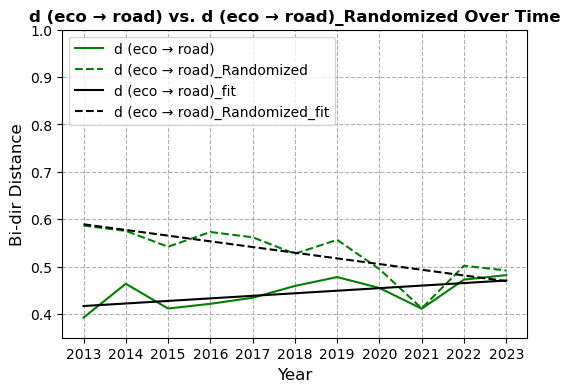

In [42]:
# Set the figure size as 10*6
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot the d_eco_road and d_eco_road_control columns on the primary y-axis
ax1.plot(results['year'], results['d_eco_road'], label='d (eco → road)', color='green')
ax1.plot(results['year'], results['d_eco_road_control'], label='d (eco → road)_Randomized', linestyle='--', color='green')

# Add linear fit line for d_eco_road
coeffs = np.polyfit(results['year'], results['d_eco_road'], 1)  # 1st-degree polynomial (linear fit)
fit_line = np.poly1d(coeffs)(results['year'])
ax1.plot(results['year'], fit_line, linestyle='-', color='black', alpha=1, label='d (eco → road)_fit')

# Add linear fit line for d_eco_road_control
coeffs_control = np.polyfit(results['year'], results['d_eco_road_control'], 1)
fit_line_control = np.poly1d(coeffs_control)(results['year'])
ax1.plot(results['year'], fit_line_control, linestyle='--', color='black', alpha=1, label='d (eco → road)_Randomized_fit')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Bi-dir Distance', fontsize=12)
ax1.legend(loc='upper left')
ax1.set_ylim(0.35, 1.0)

# Set the title of the graph, set the font size to 16
plt.title("d (eco → road) vs. d (eco → road)_Randomized Over Time", fontsize=12, fontweight='bold')

# Set the x-ticks to be the year from 2013 to 2023 for each one year
plt.xticks(range(2013, 2024))

# Plot the grid in the graph
plt.grid(which='both', linestyle='--')

# Show the plot
plt.show()

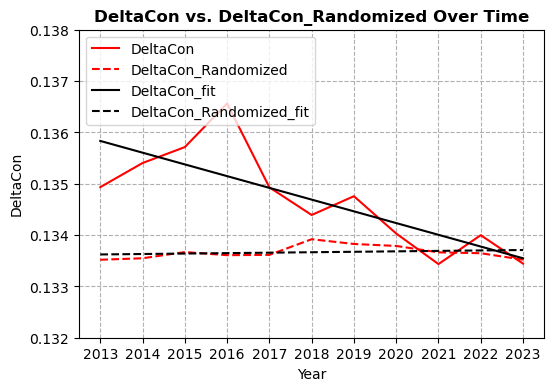

In [43]:
# Set the figure size as 10*6
fig, ax2 = plt.subplots(figsize=(6, 4))

# Plot the DeltaCon and DeltaCon_control columns on the primary y-axis
ax2.plot(results['year'], results['DeltaCon'], label='DeltaCon', color='red')
ax2.plot(results['year'], results['DeltaCon_control'], label='DeltaCon_Randomized', linestyle='--', color='red')

# Add linear fit line for DeltaCon
coeffs = np.polyfit(results['year'], results['DeltaCon'], 1)  # 1st-degree polynomial (linear fit)
fit_line = np.poly1d(coeffs)(results['year'])
ax2.plot(results['year'], fit_line, linestyle='-', color='black', alpha=1, label='DeltaCon_fit')

# Add linear fit line for DeltaCon_control
coeffs_control = np.polyfit(results['year'], results['DeltaCon_control'], 1)
fit_line_control = np.poly1d(coeffs_control)(results['year'])
ax2.plot(results['year'], fit_line_control, linestyle='--', color='black', alpha=1, label='DeltaCon_Randomized_fit')

ax2.set_xlabel('Year')
ax2.set_ylabel('DeltaCon')
ax2.legend(loc='upper left')
ax2.set_ylim(0.1320, 0.1380)

# Set the title of the graph
plt.title("DeltaCon vs. DeltaCon_Randomized Over Time", fontsize=12, fontweight='bold')

# Set the x-ticks to be the year from 2013 to 2023 for each one year
plt.xticks(range(2013, 2024))

# Plot the grid in the graph
plt.grid(which='both', linestyle='--')

# Show the plot
plt.show()